In [98]:
import pandas as pd
import numpy as np
from numpy import hstack, array
import matplotlib.pyplot as plt
import yfinance as yf
from pmdarima import auto_arima, ARIMA
from arch import arch_model


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape


import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from math import sqrt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from keras.models import Sequential
from keras.layers import Dense, Masking, LSTM



In [2]:
btc = yf.Ticker("BTC-USD")
btc_history = btc.history(period = "max", end='2024-05-25')
#history = btc.history(start='2022-05-18', end='2024-04-30', interval = '1h')
btc_history = btc_history.drop(["Dividends", "Stock Splits"], axis = 1) # удаляю Dividends и Stock Splits так как они пустые (у криптовалюты нет дивидендов)
btc_history

,Open,High,Low,Close,Volume
Date,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100
...,...,...,...,...,...
2024-05-20 00:00:00+00:00,66278.742188,71483.562500,66086.171875,71448.195312,43850655717
2024-05-21 00:00:00+00:00,71443.062500,71946.460938,69191.125000,70136.531250,46932005990
2024-05-22 00:00:00+00:00,70135.320312,70623.695312,68977.695312,69122.335938,32802561717


In [3]:
df = btc_history["Close"]

In [4]:
#dataframe = pd.DataFrame({'Date':df.index, 'Close':df.values})

In [5]:
df.head(), df.tail(), df.shape

(Date
 2014-09-17 00:00:00+00:00    457.334015
 2014-09-18 00:00:00+00:00    424.440002
 2014-09-19 00:00:00+00:00    394.795990
 2014-09-20 00:00:00+00:00    408.903992
 2014-09-21 00:00:00+00:00    398.821014
 Name: Close, dtype: float64,
 Date
 2024-05-20 00:00:00+00:00    71448.195312
 2024-05-21 00:00:00+00:00    70136.531250
 2024-05-22 00:00:00+00:00    69122.335938
 2024-05-23 00:00:00+00:00    67929.562500
 2024-05-24 00:00:00+00:00    68526.101562
 Name: Close, dtype: float64,
 (3538,))

<Axes: xlabel='Date'>

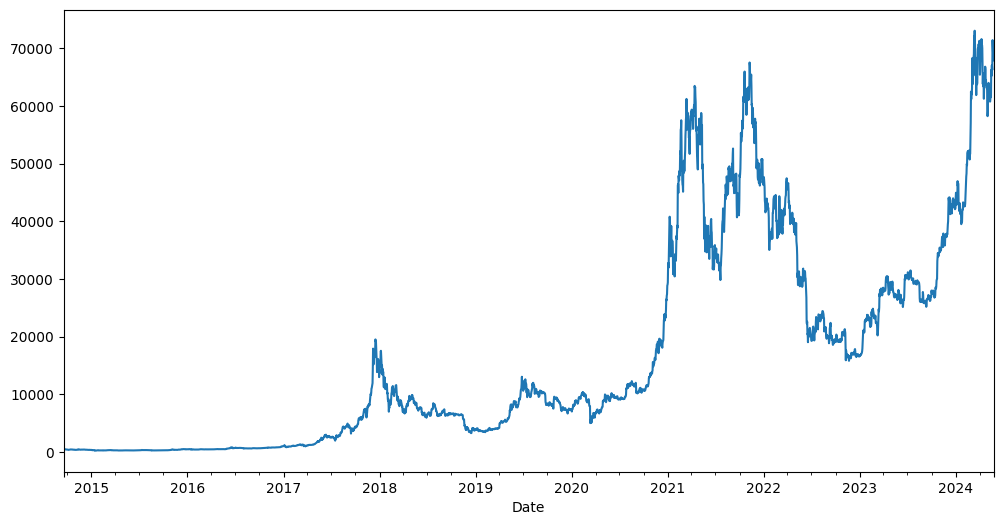

In [6]:
df.plot(figsize=(12,6))

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
     

In [8]:
btc_history.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

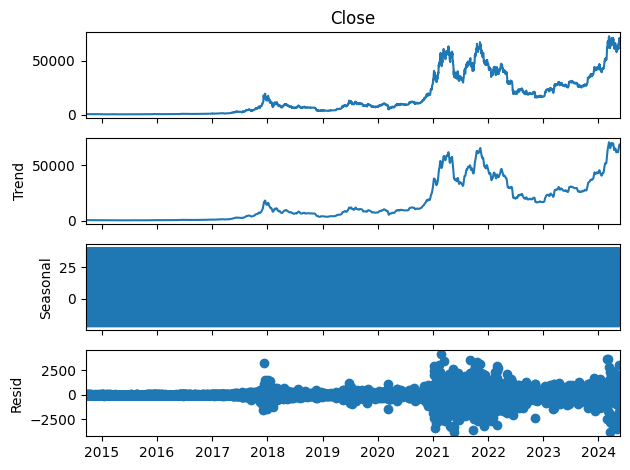

In [9]:
results = seasonal_decompose(btc_history['Close'])
results.plot();

Проверим данные на стационарность используя тест Дики-Фуллера

In [10]:
from statsmodels.tsa.stattools import adfuller
def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)


In [11]:
ad_test(df)  # p-value > 0.05; Data is not stationary

1. ADF :  -0.62580115009061
2. P-Value :  0.8650448040466583
3. Num Of Lags :  28
4. Num Of Observations Used For ADF Regression: 3509
5. Critical Values :
	 1% :  -3.4322149444714065
	 5% :  -2.8623640267493293
	 10% :  -2.567208643634359


In [12]:
ad_test(btc_history['Volume']) # только Volume стационарный среди параметров в History

1. ADF :  -2.3517741760761948
2. P-Value :  0.15581274212539103
3. Num Of Lags :  29
4. Num Of Observations Used For ADF Regression: 3508
5. Critical Values :
	 1% :  -3.4322154764873143
	 5% :  -2.8623642617472096
	 10% :  -2.5672087687403544


# Попробуем избавиться от стационарности

In [13]:
df['биткоин_без_тренда'] = df - df.rolling(window=2).mean() # убираем среднее в окне между двумя значениями

C:\Users\User\AppData\Local\Temp\ipykernel_16876\3030915947.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['биткоин_без_тренда'] = df - df.rolling(window=2).mean() # убираем среднее в окне между двумя значениями


In [14]:
df['биткоин_без_тренда_и_сезонности'] = df['биткоин_без_тренда'].diff() #Преобразование для удаления сезонности (в данном случае просто разница между текущим и предыдущим значением)

In [15]:
# появилось NA значение 
print(df['биткоин_без_тренда_и_сезонности'].isnull().sum().sum ())
# появилось NA значение 
print(df['биткоин_без_тренда'].isnull().sum().sum ())

2
1


In [16]:
df['биткоин_без_тренда_и_сезонности'].dropna(inplace=True) # Удалим первые строки с пропущенными значениями
df['биткоин_без_тренда'].dropna(inplace=True) # Удалим первые строки с пропущенными значениями

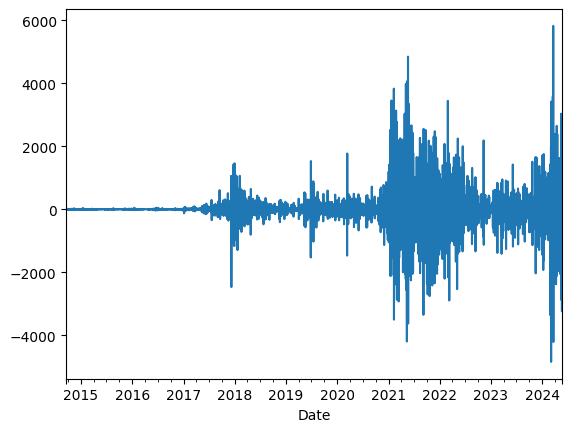

In [17]:
df['биткоин_без_тренда_и_сезонности'].plot();

In [18]:
ad_test(df['биткоин_без_тренда_и_сезонности'])  # p-value < 0.05; Data is stationary.  pv = 1.9341189930150036e-15 - для биткоин_без_тренда  > 2.235617394452057e-30 - для биткоин_без_тренда_и_сезонности (вывод оба ряда стационарны, но без сезонности с еще большей точностью)

1. ADF :  -18.48466270150043
2. P-Value :  2.1308733500292354e-30
3. Num Of Lags :  30
4. Num Of Observations Used For ADF Regression: 3505
5. Critical Values :
	 1% :  -3.432217074357827
	 5% :  -2.8623649675457465
	 10% :  -2.5672091444868856


# ARIMA

In [19]:
from pmdarima import auto_arima


Попробуем подобрать модель ARIMA на трех полученных df. (не стационарном, стационарном - биткоин_без_тренда, стационарном - биткоин_без_тренда_и_сезонности)
И сравним их по показателю AIC

Обучать будем на треин датасете (все имеющиеся данные без последних 30 дней)

In [20]:
print(df.shape)
train= btc_history["Close"].iloc[:-30]
test = btc_history["Close"].iloc[-30:]
print(train.shape, test.shape)

(3540,)
(3508,) (30,)


In [21]:
print(df['биткоин_без_тренда'].shape)
train_no_trend=df['биткоин_без_тренда'].iloc[:-30]
test_no_trend=df['биткоин_без_тренда'].iloc[-30:]
print(train_no_trend.shape,test_no_trend.shape)

(3537,)
(3507,) (30,)


In [22]:
print(df['биткоин_без_тренда_и_сезонности'].shape)
train_no_trend_no_s = df['биткоин_без_тренда_и_сезонности'].iloc[:-30]
test_no_trend_no_s = df['биткоин_без_тренда_и_сезонности'].iloc[-30:]
print(train_no_trend.shape,test_no_trend.shape)

(3536,)
(3507,) (30,)


Some Trials, you can skip them to best models

Ищем лучшую ARIMA / SARIMA модель среди отобранных датасетов

In [23]:
ARIMA_MODEL_1 = auto_arima(train, suppress_warnings=True) #, trace=True) #  ARIMA(4,1,2)(0,0,0)[0]  AIC=57162.824

In [24]:
ARIMA_MODEL_1.summary() #  ARIMA(4,1,2)(0,0,0)[0]  AIC=57162.824

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3508
Model:               SARIMAX(4, 1, 2)   Log Likelihood              -28574.412
Date:                Sat, 01 Jun 2024   AIC                          57162.824
Time:                        03:40:37   BIC                          57205.962
Sample:                    09-17-2014   HQIC                         57178.218
                         - 04-24-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7919      0.013     61.133      0.000       0.766       0.817
ar.L2         -0.8945      0.014    -62.470      0.000      -0.923      -0.866
ar.L3         -0.0465      0.012     -3.945      0.000      -0.070      -0.023
ar.L4          0.0304      0.009      3.365      0.001       0.013       0.048
ma.L1         -0.8447      0.010    -80.711      0.000      -0.865      -0.824
ma.L2          0.9547      0.010     95.095      0.000       0.935       0.974
sigma2       7.04e+05   6046.766    116.418      0.000    6.92e+05    7.16e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             30060.42
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):             228.38   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
ARIMA_MODEL_1_S = auto_arima(train, suppress_warnings=True,  m=12, seasonal=True, trace=True)  #  ARIMA(4,1,2)(0,0,0)[0]  AIC=57162.824

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=57134.714, Time=4.02 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=57186.771, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=57173.430, Time=0.38 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=57174.558, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=57186.415, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=57156.412, Time=3.07 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=57154.477, Time=3.64 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=57133.661, Time=10.69 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=57143.726, Time=9.69 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=57124.381, Time=17.09 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=57133.285, Time=11.37 sec
 ARIMA(1,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=12.61 sec
 ARIMA(2,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=12.17 sec
 ARIMA(3,1,2)(2,0,2)[12] intercept   : AIC=57134.702, Time=17.03 sec
 ARIMA(2,1,

In [26]:
ARIMA_MODEL_1_S.summary() #  SARIMA(2, 1, 3)x(2, 0, [1, 2], 12)  AIC=57121.010

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                 3508
Model:             SARIMAX(2, 1, 3)x(2, 0, [1, 2], 12)   Log Likelihood              -28550.505
Date:                                 Sat, 01 Jun 2024   AIC                          57121.010
Time:                                         03:47:43   BIC                          57182.635
Sample:                                     09-17-2014   HQIC                         57143.001
                                          - 04-24-2024                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3684      0.011    125.938      0.000       1.347       1.390
ar.L2         -0.9367      0.010    -97.371      0.000      -0.956      -0.918
ma.L1         -1.4168      0.013   -105.637      0.000      -1.443      -1.391
ma.L2          1.0221      0.015     67.208      0.000       0.992       1.052
ma.L3         -0.0387      0.009     -4.253      0.000      -0.057      -0.021
ar.S.L12      -1.5267      0.087    -17.545      0.000      -1.697      -1.356
ar.S.L24      -0.7034      0.069    -10.184      0.000      -0.839      -0.568
ma.S.L12       1.4723      0.085     17.236      0.000       1.305       1.640
ma.S.L24       0.6885      0.062     11.188      0.000       0.568       0.809
sigma2       7.05e+05   6292.423    112.039      0.000    6.93e+05    7.17e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             28233.96
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):             231.65   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Посмотрим на лучшую модель для датасета без тренда

In [27]:
ARIMA_MODEL_2 = auto_arima(train_no_trend, suppress_warnings=True) #  ARIMA(4,0,2)(0,0,0)[0]  AIC=52301.081

In [28]:
ARIMA_MODEL_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3507
Model:               SARIMAX(4, 0, 2)   Log Likelihood              -26143.541
Date:                Sat, 01 Jun 2024   AIC                          52301.081
Time:                        03:48:02   BIC                          52344.219
Sample:                    09-18-2014   HQIC                         52316.475
                         - 04-24-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7915      0.013     60.755      0.000       0.766       0.817
ar.L2         -0.8944      0.014    -62.226      0.000      -0.923      -0.866
ar.L3         -0.0465      0.012     -3.947      0.000      -0.070      -0.023
ar.L4          0.0306      0.009      3.386      0.001       0.013       0.048
ma.L1         -0.8442      0.011    -79.925      0.000      -0.865      -0.823
ma.L2          0.9543      0.010     94.116      0.000       0.934       0.974
sigma2      1.759e+05   1510.327    116.471      0.000    1.73e+05    1.79e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             30071.32
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):             228.37   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

добавим сезонность

In [29]:
ARIMA_MODEL_2_S = auto_arima(train_no_trend, suppress_warnings=True,  m=12, seasonal=True, trace=True) #  SARIMA(2, 0, 3)x(2, 0, [1, 2], 12)  AIC=52259.317 

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=52272.970, Time=4.02 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=52325.036, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=52311.699, Time=0.29 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=52312.827, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=52324.681, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=52294.641, Time=3.55 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=52292.719, Time=3.06 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=52271.909, Time=9.46 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=52281.948, Time=9.24 sec
 ARIMA(2,0,2)(2,0,2)[12] intercept   : AIC=52262.903, Time=17.26 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=52271.528, Time=11.38 sec
 ARIMA(1,0,2)(2,0,2)[12] intercept   : AIC=inf, Time=13.91 sec
 ARIMA(2,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=11.00 sec
 ARIMA(3,0,2)(2,0,2)[12] intercept   : AIC=52272.768, Time=19.59 sec
 ARIMA(2,0,3

In [30]:
ARIMA_MODEL_2_S.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                 3507
Model:             SARIMAX(2, 0, 3)x(2, 0, [1, 2], 12)   Log Likelihood              -26119.658
Date:                                 Sat, 01 Jun 2024   AIC                          52259.317
Time:                                         03:54:39   BIC                          52320.942
Sample:                                     09-18-2014   HQIC                         52281.308
                                          - 04-24-2024                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3709      0.011    126.764      0.000       1.350       1.392
ar.L2         -0.9388      0.010    -97.872      0.000      -0.958      -0.920
ma.L1         -1.4172      0.013   -106.097      0.000      -1.443      -1.391
ma.L2          1.0214      0.015     67.494      0.000       0.992       1.051
ma.L3         -0.0376      0.009     -4.141      0.000      -0.055      -0.020
ar.S.L12      -1.5319      0.086    -17.784      0.000      -1.701      -1.363
ar.S.L24      -0.7022      0.069    -10.178      0.000      -0.837      -0.567
ma.S.L12       1.4766      0.085     17.464      0.000       1.311       1.642
ma.S.L24       0.6870      0.061     11.204      0.000       0.567       0.807
sigma2      1.761e+05   1571.346    112.098      0.000    1.73e+05    1.79e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):             28210.45
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):             231.54   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
ARIMA_MODEL_3 = auto_arima(train_no_trend_no_s, suppress_warnings=True) #  ARIMA(5,0,0)(0,0,0)[0]  AIC=52796.708

In [32]:
ARIMA_MODEL_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3506
Model:               SARIMAX(5, 0, 0)   Log Likelihood              -26392.354
Date:                Sat, 01 Jun 2024   AIC                          52796.708
Time:                        03:54:47   BIC                          52833.681
Sample:                    09-19-2014   HQIC                         52809.902
                         - 04-24-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8996      0.008   -116.688      0.000      -0.915      -0.884
ar.L2         -0.7271      0.011    -66.889      0.000      -0.748      -0.706
ar.L3         -0.5241      0.012    -42.808      0.000      -0.548      -0.500
ar.L4         -0.3187      0.012    -27.319      0.000      -0.342      -0.296
ar.L5         -0.1519      0.008    -18.379      0.000      -0.168      -0.136
sigma2      2.026e+05   1777.176    113.976      0.000    1.99e+05    2.06e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.08   Jarque-Bera (JB):             26932.58
Prob(Q):                              0.30   Prob(JB):                         0.00
Heteroskedasticity (H):             238.86   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

к этой модели сезонность добавлять не логично, так как мы ее уничтожили в ходе преобразования исходного датафрейма

# Модель с датасетом "биткоин_без_тренда" оказалась лучшей по AIC 

In [33]:
ARIMA_MODEL_2_S = auto_arima(train_no_trend, suppress_warnings=True,  m=12, seasonal=True, trace=True) # лучшая по AIC

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=52272.970, Time=4.07 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=52325.036, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=52311.699, Time=0.26 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=52312.827, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=52324.681, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=52294.641, Time=3.45 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=52292.719, Time=3.04 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=52271.909, Time=9.45 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=52281.948, Time=9.25 sec
 ARIMA(2,0,2)(2,0,2)[12] intercept   : AIC=52262.903, Time=17.37 sec
 ARIMA(2,0,2)(1,0,2)[12] intercept   : AIC=52271.528, Time=11.43 sec
 ARIMA(1,0,2)(2,0,2)[12] intercept   : AIC=inf, Time=13.94 sec
 ARIMA(2,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=10.82 sec
 ARIMA(3,0,2)(2,0,2)[12] intercept   : AIC=52272.768, Time=20.01 sec
 ARIMA(2,0,3

предскажем на 30 дней вперед (по 1 дню с добавлением нового значения)

In [34]:
def forecast_one_step_1():
    fc, conf_int = ARIMA_MODEL_2_S.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

In [35]:
forecasts = []
confidence_intervals = []

for new_ob in test_no_trend:
    fc, conf = forecast_one_step_1()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    ARIMA_MODEL_2_S.update(new_ob)

rmse=sqrt(mean_squared_error(forecasts,test_no_trend))
print(f"Root Mean squared error: {rmse}") 
print(f"Mean squared error: {mean_squared_error(test_no_trend, forecasts)}") 
print(f"SMAPE: {smape(test_no_trend, forecasts)}")

# Root Mean squared error: 969.9832300780425
# Mean squared error: 940867.4666326328
# SMAPE: 173.24732617648633

Root Mean squared error: 969.9832300780425
Mean squared error: 940867.4666326328
SMAPE: 173.24732617648633


Но она предсказывает значения которые еще нужно перевести обратно с трендом

поэтому 


## Попробуем модель работающую сразу с трендом для предсказния сразу на 30 периодов

In [92]:
ARIMA_MODEL_1_S_pred_1 = auto_arima(train, suppress_warnings=True,  m=12, seasonal=True, trace=True, max_p = 30, max_q = 30) 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=57134.714, Time=3.90 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=57186.771, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=57173.430, Time=0.29 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=57174.558, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=57186.415, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=57156.412, Time=3.00 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=57154.477, Time=3.55 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=57133.661, Time=10.26 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=57143.726, Time=9.39 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=57124.381, Time=16.65 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=57133.285, Time=11.36 sec
 ARIMA(1,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=12.65 sec
 ARIMA(2,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=12.23 sec
 ARIMA(3,1,2)(2,0,2)[12] intercept   : AIC=57134.702, Time=17.04 sec
 ARIMA(2,1,

In [93]:
fc = ARIMA_MODEL_1_S_pred_1.predict(n_periods=30, )
rmse=sqrt(mean_squared_error(fc,test))
print(f"Root Mean squared error: {rmse}") 
print(f"Mean squared error: {mean_squared_error(test, fc)}") 
print(f"SMAPE: {smape(test, fc)}")

Root Mean squared error: 3179.041057736404
Mean squared error: 10106302.046773795
SMAPE: 3.6834072634822808


In [94]:
test_df_fc = test.to_frame()
test_df_fc['SARIMA Forecast 30 days'] = fc
test_df_fc

,Close,SARIMA Forecast 30 days
Date,,
2024-04-25 00:00:00+00:00,64481.707031,64320.387170
2024-04-26 00:00:00+00:00,63755.320312,63974.979630
2024-04-27 00:00:00+00:00,63419.140625,64068.210563
2024-04-28 00:00:00+00:00,63113.230469,64025.067095
2024-04-29 00:00:00+00:00,63841.121094,63767.769290
2024-04-30 00:00:00+00:00,60636.855469,63635.896516
2024-05-01 00:00:00+00:00,58254.011719,63702.314895
2024-05-02 00:00:00+00:00,59123.433594,63933.686787
2024-05-03 00:00:00+00:00,62889.835938,63532.319176


<Axes: xlabel='Date'>

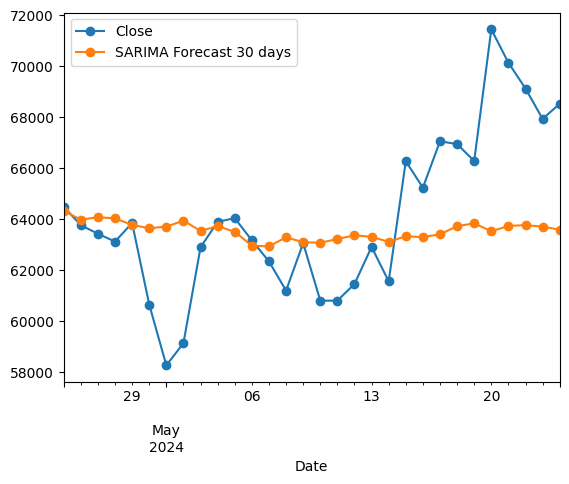

In [95]:
test_df_fc.plot(marker='o', label = True)

In [96]:
def forecast_one_step_1():
    fc, conf_int = ARIMA_MODEL_1_S_pred_1.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

In [97]:
forecasts = []
confidence_intervals = []

for new_ob in test:
    fc, conf = forecast_one_step_1()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    ARIMA_MODEL_1_S_pred_1.update(new_ob)

rmse=sqrt(mean_squared_error(forecasts,test))
print(f"Root Mean squared error: {rmse}") 
print(f"Mean squared error: {mean_squared_error(test, forecasts)}") 
print(f"SMAPE: {smape(test, forecasts)}")

# Root Mean squared error: 1940.9687672379732
# Mean squared error: 3767359.755393298
# SMAPE: 2.228641361828634

Root Mean squared error: 1940.9687672379732
Mean squared error: 3767359.755393298
SMAPE: 2.228641361828634


In [40]:
test_df = test.to_frame()
test_df['SARIMAForecast'] = forecasts
test_df

,Close,SARIMAForecast
Date,,
2024-04-25 00:00:00+00:00,64481.707031,64320.387170
2024-04-26 00:00:00+00:00,63755.320312,64127.567834
2024-04-27 00:00:00+00:00,63419.140625,63870.854313
2024-04-28 00:00:00+00:00,63113.230469,63395.964638
2024-04-29 00:00:00+00:00,63841.121094,62851.955290
2024-04-30 00:00:00+00:00,60636.855469,63634.615468
2024-05-01 00:00:00+00:00,58254.011719,60841.193966
2024-05-02 00:00:00+00:00,59123.433594,58574.865596
2024-05-03 00:00:00+00:00,62889.835938,58583.799825


<Axes: xlabel='Date'>

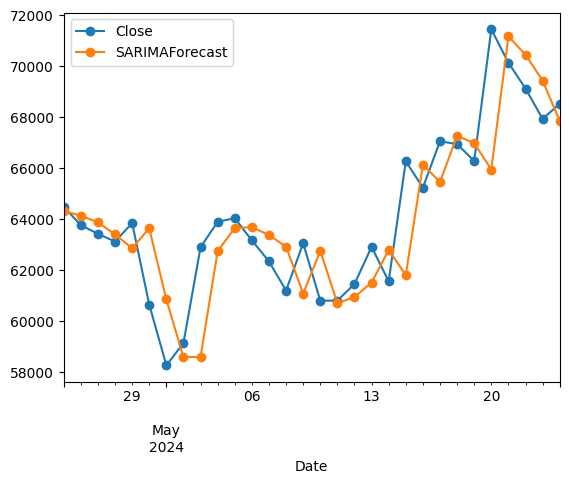

In [41]:
test_df.plot(marker='o', label = True)

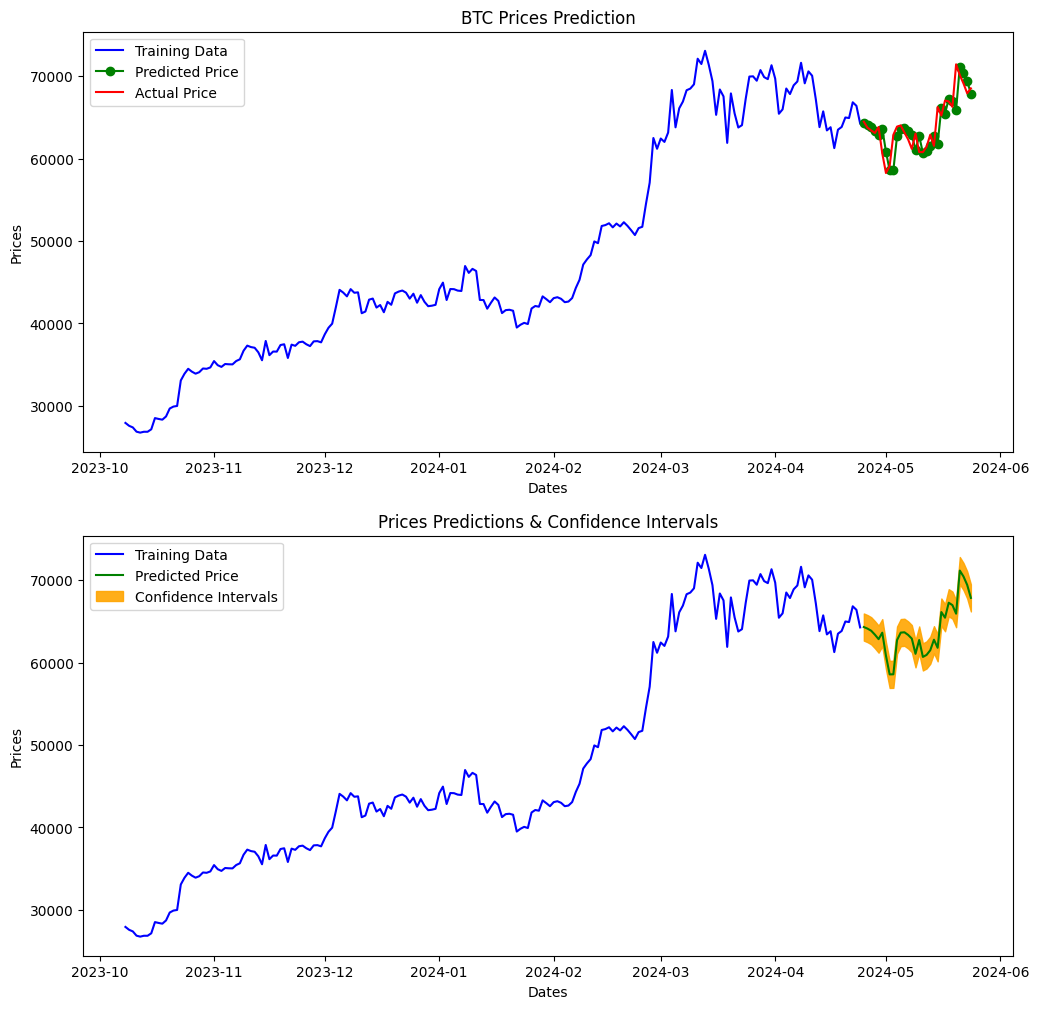

In [42]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(train[-200:], color='blue', label='Training Data')
axes[0].plot(test.index, forecasts, color='green', marker='o',
             label='Predicted Price')

axes[0].plot(test.index, test, color='red', label='Actual Price')
axes[0].set_title('BTC Prices Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Prices')


axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(train[-200:], color='blue', label='Training Data')
axes[1].plot(test.index, forecasts, color='green',
             label='Predicted Price')

axes[1].set_title('Prices Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Prices')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(test.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")


axes[1].legend()

## Попробую добавить ARCH, GARCH к ARIMA (временно игнор)

In [43]:
ARIMA_MODEL_1_S = auto_arima(train, suppress_warnings=True,  m=12, seasonal=True, trace=True) 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=57134.714, Time=3.89 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=57186.771, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=57173.430, Time=0.30 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=57174.558, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=57186.415, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=57156.412, Time=2.97 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=57154.477, Time=3.53 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=57133.661, Time=10.48 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=57143.726, Time=9.50 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=57124.381, Time=16.68 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=57133.285, Time=11.44 sec
 ARIMA(1,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=12.80 sec
 ARIMA(2,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=12.13 sec
 ARIMA(3,1,2)(2,0,2)[12] intercept   : AIC=57134.702, Time=17.07 sec
 ARIMA(2,1,

In [99]:
residuals = ARIMA_MODEL_1_S.resid() # остатки train

In [100]:
residuals

Date
2014-09-17 00:00:00+00:00     457.334015
2014-09-18 00:00:00+00:00     -24.118898
2014-09-19 00:00:00+00:00     -34.089967
2014-09-20 00:00:00+00:00       7.531220
2014-09-21 00:00:00+00:00     -12.811656
                                ...     
2024-04-20 00:00:00+00:00    1302.755886
2024-04-21 00:00:00+00:00    -642.186290
2024-04-22 00:00:00+00:00    2295.470018
2024-04-23 00:00:00+00:00    -598.941869
2024-04-24 00:00:00+00:00   -2896.748553
Length: 3508, dtype: float64

In [106]:
from statsmodels.stats.diagnostic import het_arch


In [108]:
arch_test = het_arch(residuals)
arch_test

(545.0413952504823,
 1.0316903214473817e-110,
 64.36119159210647,
 1.2814185213638743e-120)

1.0316903214473817e-110 < 0.05 в остатках присутствует гетероскедастичность

функция определяет лучший GARCH, но на практике обычно используют 1, 1

In [45]:
def find_best_garch_model(residuals, p_range, q_range):
    best_aic = np.inf
    best_order = None
    best_model = None

    for p, q in itertools.product(p_range, q_range):
        try:
            model = arch_model(residuals, vol='Garch', p=p, q=q)
            result = model.fit(disp='off')
            if result.aic < best_aic:
                best_aic = result.aic
                best_order = (p, q)
                best_model = result
        except Exception as e:
            print(f"Model fitting failed for (p, q)=({p}, {q}): {e}")
            continue

    return best_order, best_model

# Диапазоны значений p и q для перебора
p_range = range(1, 5)
q_range = range(1, 5)

# Поиск лучших параметров GARCH
best_order, best_garch_model = find_best_garch_model(residuals, p_range, q_range)

print(f"Best GARCH order: {best_order}")
print(best_garch_model.summary())


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.89e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The sc

Best GARCH order: (2, 4)
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -23704.4
Distribution:                  Normal   AIC:                           47424.8
Method:            Maximum Likelihood   BIC:                           47474.1
                                        No. Observations:                 3508
Date:                Sat, Jun 01 2024   Df Residuals:                     3507
Time:                        04:18:41   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2574      0.311      0.828  

In [133]:
residuals[-60:-30]

Date
2024-02-25 00:00:00+00:00     112.935571
2024-02-26 00:00:00+00:00    2937.767545
2024-02-27 00:00:00+00:00    2482.556939
2024-02-28 00:00:00+00:00    5457.765064
2024-02-29 00:00:00+00:00   -1124.734255
2024-03-01 00:00:00+00:00     917.870090
2024-03-02 00:00:00+00:00    -536.350050
2024-03-03 00:00:00+00:00    1036.604946
2024-03-04 00:00:00+00:00    5251.997211
2024-03-05 00:00:00+00:00   -4028.140807
2024-03-06 00:00:00+00:00    2117.754654
2024-03-07 00:00:00+00:00     725.468990
2024-03-08 00:00:00+00:00    1359.724806
2024-03-09 00:00:00+00:00      71.202149
2024-03-10 00:00:00+00:00     683.366485
2024-03-11 00:00:00+00:00    3372.187785
2024-03-12 00:00:00+00:00    -480.496695
2024-03-13 00:00:00+00:00    1727.694966
2024-03-14 00:00:00+00:00   -1617.290729
2024-03-15 00:00:00+00:00   -2146.109469
2024-03-16 00:00:00+00:00   -3940.048101
2024-03-17 00:00:00+00:00    2635.516579
2024-03-18 00:00:00+00:00    -333.749847
2024-03-19 00:00:00+00:00   -5281.328048
2024-03-20 

In [127]:
residuals[-3:]

Date
2024-03-25 00:00:00+00:00    2892.910109
2024-03-26 00:00:00+00:00     174.575418
2024-03-27 00:00:00+00:00    -579.101471
2024-03-28 00:00:00+00:00     586.943905
2024-03-29 00:00:00+00:00    -513.082618
2024-03-30 00:00:00+00:00    -657.398397
2024-03-31 00:00:00+00:00    1200.342295
2024-04-01 00:00:00+00:00   -1238.643192
2024-04-02 00:00:00+00:00   -4272.427645
2024-04-03 00:00:00+00:00     499.160624
2024-04-04 00:00:00+00:00    2782.699393
2024-04-05 00:00:00+00:00    -225.286483
2024-04-06 00:00:00+00:00    1134.864072
2024-04-07 00:00:00+00:00     495.004923
2024-04-08 00:00:00+00:00    2162.956158
2024-04-09 00:00:00+00:00   -1870.456137
2024-04-10 00:00:00+00:00     842.153145
2024-04-11 00:00:00+00:00    -157.964257
2024-04-12 00:00:00+00:00   -2176.473714
2024-04-13 00:00:00+00:00   -3726.077758
2024-04-14 00:00:00+00:00    1678.324720
2024-04-15 00:00:00+00:00   -2101.707330
2024-04-16 00:00:00+00:00     373.747585
2024-04-17 00:00:00+00:00   -2856.020387
2024-04-18 

In [134]:
garch_model_1_1 = arch_model(residuals[-60:-30], vol='Garch', p=1, q=1)

In [135]:
garch_results = garch_model_1_1.fit(disp='off')

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.367e+06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.01 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [138]:
# Прогнозирование волатильности с помощью GARCH
garch_forecast = garch_results.forecast(horizon=30)
garch_volatility_forecast = np.sqrt(garch_forecast.variance.values[-1:])

In [142]:
#  best_order[0], best_order[1]

(2, 4)

In [141]:
# garch_model = arch_model(residuals, vol='Garch', p=best_order[0], q=best_order[1])
# garch_result = garch_model.fit(disp='off')

In [48]:
# # Прогнозируем волатильность с GARCH
# garch_forecast = garch_result.forecast(horizon=30)
# garch_forecast_variance = garch_forecast.variance.values[-1, :]

In [49]:
# # Получаем стандартное отклонение из прогноза GARCH
# garch_forecast_std = np.sqrt(garch_forecast_variance)

In [50]:
arima_forecast = ARIMA_MODEL_1_S.predict(n_periods=30)

In [51]:
# Композитный прогноз
composite_forecast = arima_forecast + garch_volatility_forecast

In [52]:
rmse=sqrt(mean_squared_error(composite_forecast, test))
print(f"Root Mean squared error: {rmse}") 
print(f"Mean squared error: {mean_squared_error(test, composite_forecast)}") 
print(f"SMAPE: {smape(test, composite_forecast)}")

Root Mean squared error: 3443.0093928616793
Mean squared error: 11854313.67933375
SMAPE: 4.616947958044276


<Axes: xlabel='Date'>

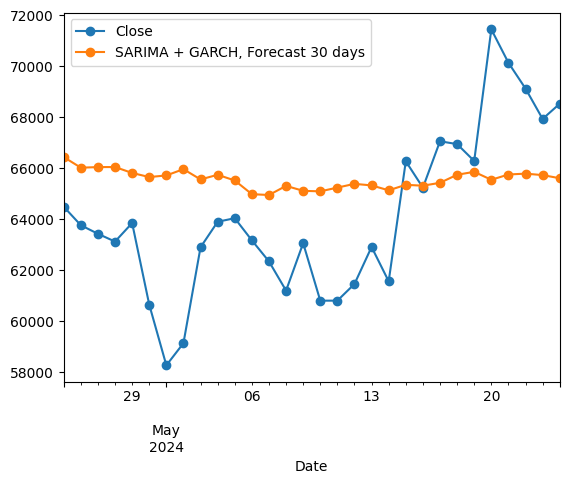

In [101]:
test_df_fc_with_GARCH = test.to_frame()
test_df_fc_with_GARCH['SARIMA + GARCH, Forecast 30 days'] = composite_forecast
test_df_fc_with_GARCH
test_df_fc_with_GARCH.plot(marker='o', label = True)

# rmse стал хуже для GARCH модели 1,1 (был около 3200 стал 3433) 

# LSTM

Для LSTM модели стационарность не является большой проблемой, но иногда покащатели на стационарном ряду лучше чем на не стационарном

Поэтому сейчас попробую обучить LSTM на нашем времянном ряду без изменений (приведения к стац.) и сравним прогноз с ARIMA

In [53]:
my_df = btc_history["Close"].to_frame(name='Close')

In [54]:
train_for_LSTM = my_df.iloc[:-30]
test_for_LSTM = my_df.iloc[-30:]

In [55]:
train_for_LSTM

,Close
Date,
2014-09-17 00:00:00+00:00,457.334015
2014-09-18 00:00:00+00:00,424.440002
2014-09-19 00:00:00+00:00,394.795990
2014-09-20 00:00:00+00:00,408.903992
2014-09-21 00:00:00+00:00,398.821014
...,...
2024-04-20 00:00:00+00:00,64994.441406
2024-04-21 00:00:00+00:00,64926.644531
2024-04-22 00:00:00+00:00,66837.679688


In [56]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_for_LSTM)
scaled_train_for_LSTM = scaler.transform(train_for_LSTM)
scaled_test_for_LSTM = scaler.transform(test_for_LSTM)

В качестве первой попытки я попробовал обучить модель предсказывать по последним 360 дням, но в дальнейшем я отказался от этого

In [57]:
# define generator
n_input = 360
n_features = 1
generator = TimeseriesGenerator(scaled_train_for_LSTM, scaled_train_for_LSTM, length=n_input, batch_size=1)


In [58]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[-0.99233991 -0.99324228 -0.9940555  -0.99366848 -0.99394508 -0.99385371
 -0.99293089 -0.99327616 -0.99359523 -0.99379135 -0.99392591 -0.99453873
 -0.99458575 -0.9942709  -0.99436223 -0.99459659 -0.99502344 -0.99586415
 -0.99609338 -0.99583087 -0.99566331 -0.99520373 -0.99487218 -0.9949672
 -0.99494699 -0.9945012  -0.99417571 -0.99388887 -0.99405613 -0.99439128
 -0.99435831 -0.99414751 -0.99419952 -0.99438335 -0.99428377 -0.99437477
 -0.99505348 -0.99505546 -0.99535925 -0.99515534 -0.99520238 -0.9950754
 -0.99567966 -0.99541318 -0.99560477 -0.99594966 -0.99594573 -0.99590014
 -0.99581954 -0.99557281 -0.99530386 -0.99549246 -0.99540816 -0.99492051
 -0.99482011 -0.99479896 -0.9932664  -0.99334392 -0.9939726  -0.99456748
 -0.99424517 -0.99425818 -0.99459313 -0.99444617 -0.99506931 -0.99526112
 -0.99520428 -0.99480231 -0.99454641 -0.99458902 -0.99478044 -0.99474478
 -0.99455887 -0.99458509 -0.99451497 -0.99448211 -0.99442532 -0.99459829
 -0.99474659 -0.9945477  -0.9946044

In [59]:
# define model
LSTM_model_360 = Sequential()
LSTM_model_360.add(LSTM(100, input_shape=(n_input, n_features)))
LSTM_model_360.add(Dense(6))
LSTM_model_360.compile(optimizer='adam', loss='mse')

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [60]:
LSTM_model_360.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,406 (161.74 KB)

 Trainable params: 41,406 (161.74 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
LSTM_model_360.fit(generator,epochs=8)

Epoch 1/15


   5/3148 ━━━━━━━━━━━━━━━━━━━━ 1:24 27ms/step - loss: 0.5830

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3148/3148 ━━━━━━━━━━━━━━━━━━━━ 85s 27ms/step - loss: 0.0127
Epoch 2/15
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 84s 27ms/step - loss: 0.0011
Epoch 3/15
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 85s 27ms/step - loss: 8.8826e-04
Epoch 4/15
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 85s 27ms/step - loss: 7.0270e-04
Epoch 5/15
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 83s 26ms/step - loss: 8.2508e-04
Epoch 6/15
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 84s 27ms/step - loss: 7.1952e-04
Epoch 7/15
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 83s 26ms/step - loss: 7.5516e-04
Epoch 8/15
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 83s 26ms/step - loss: 6.7760e-04
Epoch 9/15
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 85s 27ms/step - loss: 7.6702e-04
Epoch 10/15
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 84s 27ms/step - loss: 8.0789e-04
Epoch 11/15
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 84s 27ms/step - loss: 7.4276e-04
Epoch 12/15
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 84s 27ms/step - loss: 7.3060e-04
Epoch 13/15
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 85s 27ms/step - loss: 7.0551e-04
Epoch 14/15
3148/3148 ━━━━━━━━━━━━━━━━━━

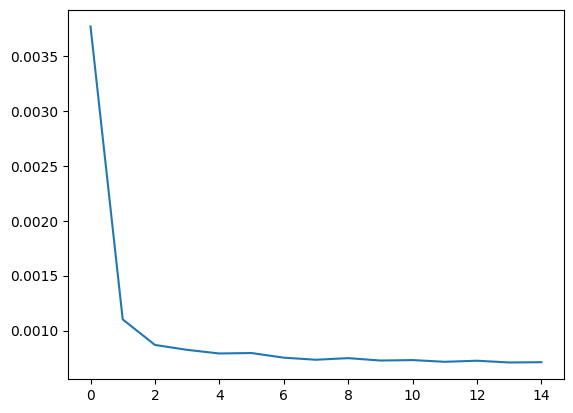

In [62]:
loss_per_epoch = LSTM_model_360.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [63]:
first_eval_batch = scaled_train_for_LSTM[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [64]:
len(current_batch[0])

360

In [65]:
test_predictions = []
for i in range(len(test_for_LSTM)):
    
    # get the prediction value for the first batch
    current_pred = LSTM_model_360.predict(current_batch)[0]
    current_pred = current_pred[-1:] 
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━

In [66]:
true_predictions = scaler.inverse_transform(test_predictions)

In [67]:

test_for_LSTM['Predictions'] = true_predictions

C:\Users\User\AppData\Local\Temp\ipykernel_16876\1528477120.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['Predictions'] = true_predictions


<Axes: xlabel='Date'>

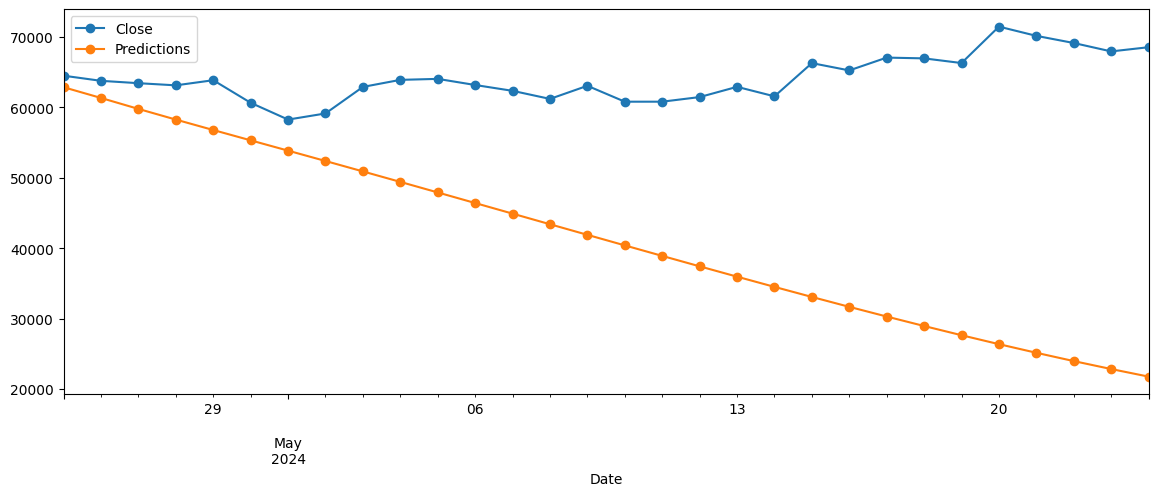

In [68]:
test_for_LSTM.plot(figsize=(14,5), marker='o', label = True)

In [69]:
rmse=sqrt(mean_squared_error(test_for_LSTM['Close'],test_for_LSTM['Predictions']))
print(f"Root Mean squared error: {rmse}") 
print(f"Mean squared error: {mean_squared_error(test_for_LSTM['Close'],test_for_LSTM['Predictions'])}") 
print(f"SMAPE: {smape(test_for_LSTM['Close'],test_for_LSTM['Predictions'])}")

Root Mean squared error: 27022.59621618458
Mean squared error: 730220706.2629532
SMAPE: 45.91055899435615


Это было Слепое предсказывание LSTM на модели со входом в 360 дней

Теперь попробую на модели в 30 дней

In [256]:
my_df = btc_history["Close"].to_frame(name='Close')
train_for_LSTM = my_df.iloc[:-30]
test_for_LSTM = my_df.iloc[-30:]

In [226]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_for_LSTM)
scaled_train_for_LSTM = scaler.transform(train_for_LSTM)
scaled_test_for_LSTM = scaler.transform(test_for_LSTM)

In [227]:
# define generator
n_input = 30
n_features = 1
generator_30 = TimeseriesGenerator(scaled_train_for_LSTM, scaled_train_for_LSTM, length=n_input, batch_size=1)

In [228]:
X,y = generator_30[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[-0.99233991 -0.99324228 -0.9940555  -0.99366848 -0.99394508 -0.99385371
 -0.99293089 -0.99327616 -0.99359523 -0.99379135 -0.99392591 -0.99453873
 -0.99458575 -0.9942709  -0.99436223 -0.99459659 -0.99502344 -0.99586415
 -0.99609338 -0.99583087 -0.99566331 -0.99520373 -0.99487218 -0.9949672
 -0.99494699 -0.9945012  -0.99417571 -0.99388887 -0.99405613 -0.99439128]
Predict this y: 
 [[-0.99435831]]


In [229]:
# define model
LSTM_model_30 = Sequential()
LSTM_model_30.add(LSTM(100, input_shape=(n_input, n_features)))
LSTM_model_30.add(Dense(5))
LSTM_model_30.add(Dense(1))
LSTM_model_30.compile(optimizer='adam', loss='mse')


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [263]:
LSTM_model_30.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           505 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,935 (484.12 KB)

 Trainable params: 41,311 (161.37 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 82,624 (322.75 KB)

In [230]:
LSTM_model_30.fit(generator_30,epochs=30)

Epoch 1/30


  53/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0460  

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0036
Epoch 2/30
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.5461e-04
Epoch 3/30
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0011
Epoch 4/30
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.3567e-04
Epoch 5/30
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.9359e-04
Epoch 6/30
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.9440e-04
Epoch 7/30
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 8.2254e-04
Epoch 8/30
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.7420e-04
Epoch 9/30
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.4665e-04
Epoch 10/30
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.6872e-04
Epoch 11/30
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.2637e-04
Epoch 12/30
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.4582e-04
Epoch 13/30
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 7.6048e-04
Epoch 14/30
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 6.

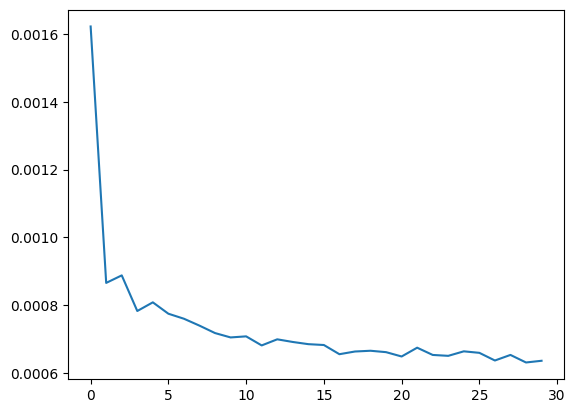

In [231]:
loss_per_epoch = LSTM_model_30.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [232]:
first_eval_batch = scaled_train_for_LSTM[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [233]:
test_predictions_30 = []
for i in range(len(test_for_LSTM)):
    
    # get the prediction value for the first batch
    current_pred = LSTM_model_30.predict(current_batch)[0]
    current_pred = current_pred[-1:] 
    
    # append the prediction into the array
    test_predictions_30.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [258]:
true_predictions = scaler.inverse_transform(test_predictions_30)
test_for_LSTM['LSTM_Predictions 30 days'] = true_predictions

C:\Users\User\AppData\Local\Temp\ipykernel_16876\2095010557.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Predictions 30 days'] = true_predictions


<Axes: xlabel='Date'>

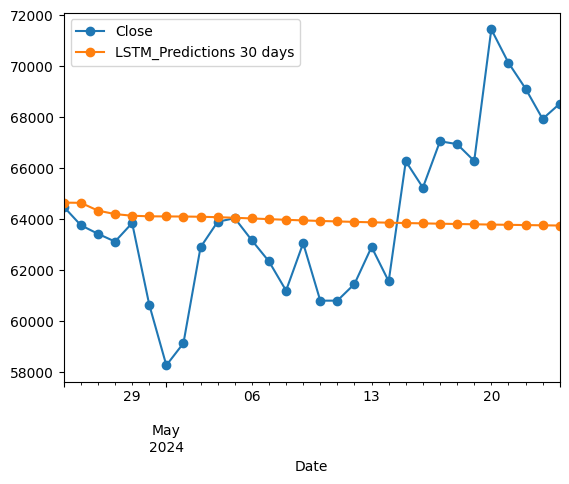

In [259]:
test_for_LSTM.plot( marker='o', label = True) #figsize=(14,5)

In [236]:
rmse=sqrt(mean_squared_error(test_for_LSTM['Close'],test_for_LSTM['Predictions']))
print(f"Root Mean squared error: {rmse}") 
print(f"Mean squared error: {mean_squared_error(test_for_LSTM['Close'],test_for_LSTM['Predictions'])}") 
print(f"SMAPE: {smape(test_for_LSTM['Close'],test_for_LSTM['Predictions'])}")

Root Mean squared error: 3274.656360714804
Mean squared error: 10723374.280769926
SMAPE: 4.04906730290995


Теперь попробую предсказывать на 1 день вперед 30 раз (не слепо) используя модель на 30 днях

In [237]:
first_eval_batch = scaled_train_for_LSTM[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [238]:
test_predictions = []
for i in range(len(test_for_LSTM)):
    
    # get the prediction value for the first batch
    current_pred = LSTM_model_30.predict(current_batch)[0]
    current_pred = current_pred[-1:] 
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[scaled_test_for_LSTM[i]]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [260]:
my_df = btc_history["Close"].to_frame(name='Close')
train_for_LSTM = my_df.iloc[:-30]
test_for_LSTM = my_df.iloc[-30:]

In [261]:
true_predictions = scaler.inverse_transform(test_predictions)
test_for_LSTM['LSTM_Forecast'] = true_predictions

C:\Users\User\AppData\Local\Temp\ipykernel_16876\1930892984.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['LSTM_Forecast'] = true_predictions


<Axes: xlabel='Date'>

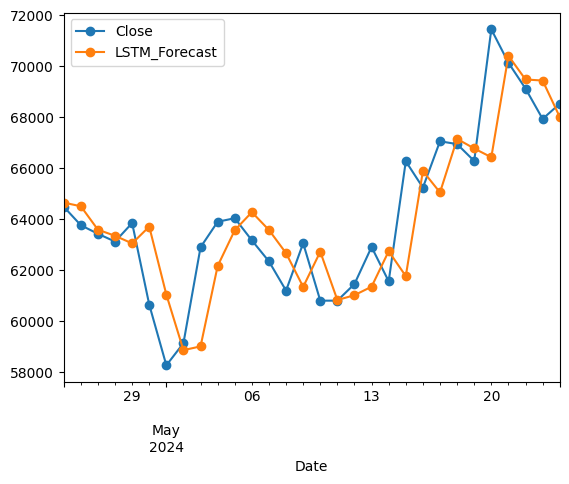

In [262]:
test_for_LSTM.plot(marker='o', label = True) #figsize=(14,5)

In [241]:
rmse=sqrt(mean_squared_error(test_for_LSTM['Close'],test_for_LSTM['Predictions']))
print(f"Root Mean squared error: {rmse}") 
print(f"Mean squared error: {mean_squared_error(test_for_LSTM['Close'],test_for_LSTM['Predictions'])}") 
print(f"SMAPE: {smape(test_for_LSTM['Close'],test_for_LSTM['Predictions'])}")

# Root Mean squared error: 1892.9732855791935
# Mean squared error: 3583347.859916487
# SMAPE: 2.046820325369942

Root Mean squared error: 1875.4253759973324
Mean squared error: 3517220.3409347353
SMAPE: 2.1200397738887093


# Выводы без SENTIMENT, чисто сравнение между LSTM и SARIMA :

SARIMA (по 1 дню с добавлением предсказаний в окно):

Root Mean squared error: 3179

SMAPE: 3.68


LSTM (по 1 дню с добавлением предсказаний в окно):

Root Mean squared error: 3274

SMAPE: 4.04


SARIMA (по 1 дню с добавлением настоящих значений в окно):

Root Mean squared error:  1940

SMAPE: 2.23


LSTM (по 1 дню с добавлением настоящих значений в окно):

Root Mean squared error: 1875

SMAPE: 2.12

Вывод LSTM и SARIMA хоть и кардинально отличаются в технологии, но прогнозы дают довольно близкие, SARIMA немного лучше на моем датасете в слепом предсказывании на 30 дней, LSTM лучше в предсказывании по 1 дню на 30 дней с добавлением настоящих значений в окно прогноза

# Теперь Попробую добавить к LSTM временной ряд отражающий SETIMENT анализ новостей криптовалюты 

Импортирую данные рбк 

In [486]:
train_for_LSTM.index = train_for_LSTM.index.date # убрал точное время из даты (оно не нужно)
test_for_LSTM.index = test_for_LSTM.index.date
my_df.index = my_df.index.date

AttributeError: 'Index' object has no attribute 'date'

In [537]:
rbk_RuBeart_Titles_Sentiment = pd.read_csv('rbk_RuBeart_Titles_Sentiment.csv')

In [538]:
rbk_RuBeart_Titles_Sentiment

,publish_date,rbk_positive,rbk_negative
0,2017-12-08,0.508701,0.491299
1,2018-02-07,0.368749,0.631251
2,2018-02-26,0.517286,0.482714
3,2018-02-26,0.401239,0.598761
4,2018-03-01,0.315074,0.684926
...,...,...,...
12370,2024-05-24,0.537387,0.462613
12371,2024-05-23,0.532352,0.467648
12372,2024-05-23,0.503831,0.496169
12373,2024-05-23,0.005241,0.994759


In [539]:
my_df

,Close,date
2014-09-17,457.334015,2014-09-17
2014-09-18,424.440002,2014-09-18
2014-09-19,394.795990,2014-09-19
2014-09-20,408.903992,2014-09-20
2014-09-21,398.821014,2014-09-21
...,...,...
2024-05-20,71448.195312,2024-05-20
2024-05-21,70136.531250,2024-05-21
2024-05-22,69122.335938,2024-05-22
2024-05-23,67929.562500,2024-05-23


In [540]:
my_df['date'] = my_df.index
my_df['date'] = pd.to_datetime(my_df['date']).dt.date

In [541]:
# Убедимся, что publish_date в формате datetime
rbk_RuBeart_Titles_Sentiment['publish_date'] = pd.to_datetime(rbk_RuBeart_Titles_Sentiment['publish_date'])


In [542]:
# Шаг 2: Агрегация значений rbk_positive и rbk_negative по дням
rbk_RuBeart_Titles_Sentiment = rbk_RuBeart_Titles_Sentiment.groupby('publish_date').mean().reset_index()


In [543]:
# Преобразование publish_date в дату без времени
rbk_RuBeart_Titles_Sentiment['publish_date'] = rbk_RuBeart_Titles_Sentiment['publish_date'].apply(lambda x: x.date())

In [544]:
# Объединение данных
merged_df = pd.merge(my_df, rbk_RuBeart_Titles_Sentiment, how='left', left_on='date', right_on='publish_date')

In [545]:
merged_df.set_index('date', inplace=True)
merged_df.drop(columns=['publish_date'], inplace=True)

In [546]:
merged_df

,Close,rbk_positive,rbk_negative
date,,,
2014-09-17,457.334015,NaN,NaN
2014-09-18,424.440002,NaN,NaN
2014-09-19,394.795990,NaN,NaN
2014-09-20,408.903992,NaN,NaN
2014-09-21,398.821014,NaN,NaN
...,...,...,...
2024-05-20,71448.195312,0.404926,0.595074
2024-05-21,70136.531250,0.412522,0.587478
2024-05-22,69122.335938,0.482541,0.517459


In [547]:
# # Шаг 3: Замаскировать пропуски в данных rbk_RuBeart_Titles_Sentiment
# merged_df['rbk_positive'] = np.ma.masked_invalid(merged_df['rbk_positive'])
# merged_df['rbk_negative'] = np.ma.masked_invalid(merged_df['rbk_negative'])

In [548]:
# Замена маскированных значений на -1
merged_df['rbk_positive'] = merged_df['rbk_positive'].fillna(-1)
merged_df['rbk_negative'] = merged_df['rbk_negative'].fillna(-1)

In [549]:
merged_df

,Close,rbk_positive,rbk_negative
date,,,
2014-09-17,457.334015,-1.000000,-1.000000
2014-09-18,424.440002,-1.000000,-1.000000
2014-09-19,394.795990,-1.000000,-1.000000
2014-09-20,408.903992,-1.000000,-1.000000
2014-09-21,398.821014,-1.000000,-1.000000
...,...,...,...
2024-05-20,71448.195312,0.404926,0.595074
2024-05-21,70136.531250,0.412522,0.587478
2024-05-22,69122.335938,0.482541,0.517459


# Данные почти готовы


In [584]:
train_for_LSTM = merged_df.iloc[:-30]
test_for_LSTM = merged_df.iloc[-30:]

In [585]:
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(train_for_LSTM['Close'].values.reshape(-1, 1))
scaled_train_for_LSTM = scaler.transform(train_for_LSTM['Close'].values.reshape(-1, 1))
scaled_test_for_LSTM = scaler.transform(test_for_LSTM['Close'].values.reshape(-1, 1))

In [586]:
# merged_df['Close'].values.reshape((len(merged_df['Close'].values), 1))

In [587]:
dataset = hstack((scaled_train_for_LSTM, train_for_LSTM['rbk_positive'].values.reshape((-1, 1)), train_for_LSTM['rbk_negative'].values.reshape((-1, 1))))

In [588]:
n_input = 30
generator = TimeseriesGenerator(dataset, scaled_train_for_LSTM, length=n_input, batch_size=1)

In [589]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[ 0.00383005 -1.         -1.          0.00337886 -1.         -1.
  0.00297225 -1.         -1.          0.00316576 -1.         -1.
  0.00302746 -1.         -1.          0.00307315 -1.         -1.
  0.00353455 -1.         -1.          0.00336192 -1.         -1.
  0.00320238 -1.         -1.          0.00310432 -1.         -1.
  0.00303705 -1.         -1.          0.00273063 -1.         -1.
  0.00270712 -1.         -1.          0.00286455 -1.         -1.
  0.00281889 -1.         -1.          0.00270171 -1.         -1.
  0.00248828 -1.         -1.          0.00206793 -1.         -1.
  0.00195331 -1.         -1.          0.00208456 -1.         -1.
  0.00216834 -1.         -1.          0.00239814 -1.         -1.
  0.00256391 -1.         -1.          0.0025164  -1.         -1.
  0.00252651 -1.         -1.          0.0027494  -1.         -1.
  0.00291214 -1.         -1.          0.00305556 -1.         -1.
  0.00297193 -1.         -1.          0.00280436 -1.         -1.        

In [590]:
n_features = X.shape[2]
n_features

3

In [591]:
mask = np.float64(-1)

In [592]:
X[0][0][1] == mask

True

In [593]:
# define model
LSTM_model_with_Pos_rbk = Sequential()
LSTM_model_with_Pos_rbk.add(Masking(mask_value=True, input_shape=(n_input, n_features)))
LSTM_model_with_Pos_rbk.add(LSTM(100))
LSTM_model_with_Pos_rbk.add(Dense(6))
LSTM_model_with_Pos_rbk.add(Dense(1))
LSTM_model_with_Pos_rbk.compile(optimizer='adam', loss='mse')


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [594]:
LSTM_model_with_Pos_rbk.fit(generator,epochs=12)

Epoch 1/12
  46/3478 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0192

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 490/3478 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0075

3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.0025
Epoch 2/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 4.7632e-04
Epoch 3/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 4.5008e-04
Epoch 4/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 3.1513e-04
Epoch 5/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 2.7146e-04
Epoch 6/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 2.6415e-04
Epoch 7/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 2.7440e-04
Epoch 8/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 2.7691e-04
Epoch 9/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 2.3711e-04
Epoch 10/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 2.4216e-04
Epoch 11/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 2.2878e-04
Epoch 12/12
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 2.3204e-04


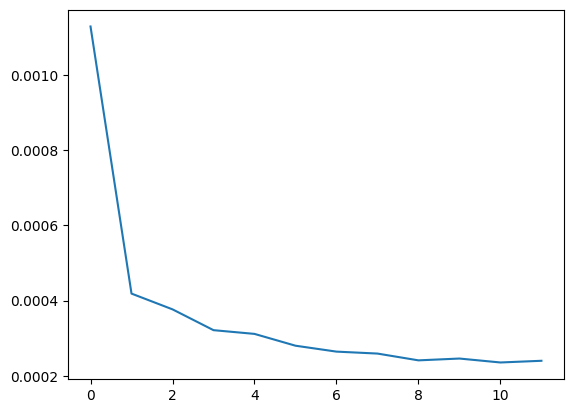

In [595]:
loss_per_epoch = LSTM_model_with_Pos_rbk.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [596]:
first_eval_batch = generator[-n_input-1][0]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [597]:
test_predictions_30 = []
for i in range(len(test_for_LSTM)):
    
    # get the prediction value for the first batch
    current_pred = LSTM_model_with_Pos_rbk.predict(current_batch)[0]
    current_pred = current_pred[-1:] 
    
    # append the prediction into the array
    test_predictions_30.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[ array([scaled_test_for_LSTM[i][0] , test_for_LSTM['rbk_positive'].iloc[i] , test_for_LSTM['rbk_negative'].iloc[i]]) ]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [598]:
true_predictions = scaler.inverse_transform(test_predictions_30)
test_for_LSTM['Predictions'] = true_predictions

C:\Users\User\AppData\Local\Temp\ipykernel_16876\1492626813.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['Predictions'] = true_predictions


In [599]:
columns_to_plot = ['Close', 'Predictions']

<Axes: xlabel='date'>

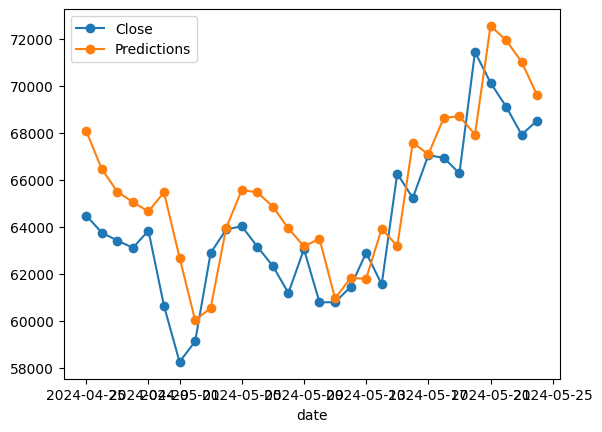

In [600]:
test_for_LSTM[columns_to_plot].plot( marker='o', label = True)

In [601]:
rmse=sqrt(mean_squared_error(test_for_LSTM['Close'],test_for_LSTM['Predictions']))
print(f"Root Mean squared error: {rmse}") 
print(f"Mean squared error: {mean_squared_error(test_for_LSTM['Close'],test_for_LSTM['Predictions'])}") 
print(f"SMAPE: {smape(test_for_LSTM['Close'],test_for_LSTM['Predictions'])}")

# Root Mean squared error: 1930.1425164308296
# Mean squared error: 3725450.133733935
# SMAPE: 2.3138564642636354

Root Mean squared error: 2416.784432668801
Mean squared error: 5840846.993990258
SMAPE: 3.193083232469385


Предсказания модели немного ухудшились после добавления sentiment - От этого берта blanchefort/rubert-base-cased-sentiment-mokoron

Root Mean squared error: 1983.0318457722224
Mean squared error: 3932415.3013467873
SMAPE: 2.4595481761963227

In [602]:
rbk_data_from_cryptobert = pd.read_csv('rbk_cryptobert_Titles_sentiment.csv')

In [603]:
# Убедимся, что publish_date в формате datetime
rbk_data_from_cryptobert['publish_date'] = pd.to_datetime(rbk_data_from_cryptobert['publish_date'])

In [604]:
# Шаг 2: Агрегация значений rbk_positive и rbk_negative по дням
rbk_data_from_cryptobert = rbk_data_from_cryptobert.groupby('publish_date').mean().reset_index()

In [605]:
# Преобразование publish_date в дату без времени
rbk_data_from_cryptobert['publish_date'] = rbk_data_from_cryptobert['publish_date'].apply(lambda x: x.date())

In [606]:
# Объединение данных
merged_df_cryptoBert = pd.merge(my_df, rbk_data_from_cryptobert, how='left', left_on='date', right_on='publish_date')
merged_df_cryptoBert.set_index('date', inplace=True)
merged_df_cryptoBert.drop(columns=['publish_date'], inplace=True)
merged_df_cryptoBert

,Close,rbk_postive_cryptobert,rbk_negative_cryptobert,rbk_neutral_cryptobert
date,,,,
2014-09-17,457.334015,NaN,NaN,NaN
2014-09-18,424.440002,NaN,NaN,NaN
2014-09-19,394.795990,NaN,NaN,NaN
2014-09-20,408.903992,NaN,NaN,NaN
2014-09-21,398.821014,NaN,NaN,NaN
...,...,...,...,...
2024-05-20,71448.195312,0.321901,0.227655,0.450444
2024-05-21,70136.531250,0.502853,0.012236,0.484911
2024-05-22,69122.335938,0.372676,0.040811,0.586513


In [607]:
# Шаг 3: Замаскировать пропуски в данных rbk_RuBeart_Titles_Sentiment
merged_df_cryptoBert['rbk_postive_cryptobert'] = np.ma.masked_invalid(merged_df_cryptoBert['rbk_postive_cryptobert'])
merged_df_cryptoBert['rbk_negative_cryptobert'] = np.ma.masked_invalid(merged_df_cryptoBert['rbk_negative_cryptobert'])
merged_df_cryptoBert['rbk_neutral_cryptobert'] = np.ma.masked_invalid(merged_df_cryptoBert['rbk_neutral_cryptobert'])

# Замена маскированных значений на -1
merged_df_cryptoBert['rbk_postive_cryptobert'] = merged_df_cryptoBert['rbk_postive_cryptobert'].fillna(np.float64(-1))
merged_df_cryptoBert['rbk_negative_cryptobert'] = merged_df_cryptoBert['rbk_negative_cryptobert'].fillna(np.float64(-1))
merged_df_cryptoBert['rbk_neutral_cryptobert'] = merged_df_cryptoBert['rbk_neutral_cryptobert'].fillna(np.float64(-1))
merged_df_cryptoBert

,Close,rbk_postive_cryptobert,rbk_negative_cryptobert,rbk_neutral_cryptobert
date,,,,
2014-09-17,457.334015,-1.000000,-1.000000,-1.000000
2014-09-18,424.440002,-1.000000,-1.000000,-1.000000
2014-09-19,394.795990,-1.000000,-1.000000,-1.000000
2014-09-20,408.903992,-1.000000,-1.000000,-1.000000
2014-09-21,398.821014,-1.000000,-1.000000,-1.000000
...,...,...,...,...
2024-05-20,71448.195312,0.321901,0.227655,0.450444
2024-05-21,70136.531250,0.502853,0.012236,0.484911
2024-05-22,69122.335938,0.372676,0.040811,0.586513


In [608]:
# merged_df_cryptoBert.iloc[1178:-30]

# Данные почти готовы

In [609]:
n_input = 30
train_for_LSTM = merged_df_cryptoBert.iloc[:-n_input]
test_for_LSTM = merged_df_cryptoBert.iloc[-n_input:]

In [610]:
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(train_for_LSTM['Close'].values.reshape(-1, 1))
scaled_train_for_LSTM = scaler.transform(train_for_LSTM['Close'].values.reshape(-1, 1))
scaled_test_for_LSTM = scaler.transform(test_for_LSTM['Close'].values.reshape(-1, 1))

In [611]:
dataset = hstack((scaled_train_for_LSTM, train_for_LSTM['rbk_postive_cryptobert'].values.reshape((-1, 1)), train_for_LSTM['rbk_negative_cryptobert'].values.reshape((-1, 1)), train_for_LSTM['rbk_neutral_cryptobert'].values.reshape((-1, 1))))

In [612]:

generator = TimeseriesGenerator(dataset, scaled_train_for_LSTM, length=n_input, batch_size=1)

In [613]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[ 0.00383005 -1.         -1.         -1.          0.00337886 -1.
 -1.         -1.          0.00297225 -1.         -1.         -1.
  0.00316576 -1.         -1.         -1.          0.00302746 -1.
 -1.         -1.          0.00307315 -1.         -1.         -1.
  0.00353455 -1.         -1.         -1.          0.00336192 -1.
 -1.         -1.          0.00320238 -1.         -1.         -1.
  0.00310432 -1.         -1.         -1.          0.00303705 -1.
 -1.         -1.          0.00273063 -1.         -1.         -1.
  0.00270712 -1.         -1.         -1.          0.00286455 -1.
 -1.         -1.          0.00281889 -1.         -1.         -1.
  0.00270171 -1.         -1.         -1.          0.00248828 -1.
 -1.         -1.          0.00206793 -1.         -1.         -1.
  0.00195331 -1.         -1.         -1.          0.00208456 -1.
 -1.         -1.          0.00216834 -1.         -1.         -1.
  0.00239814 -1.         -1.         -1.          0.00256391 -1.
 -1.   

In [614]:
n_features = X.shape[2]
n_features

4

In [615]:
type(X[0][1][1])

numpy.float64

In [616]:
mask = np.float64(-1)

In [617]:
type(mask)

numpy.float64

Epoch 1/15


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  46/3478 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0596

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1366/3478 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0098

3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.0054
Epoch 2/15
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 6.0139e-04
Epoch 3/15
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 3.7874e-04
Epoch 4/15
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 3.7842e-04
Epoch 5/15
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 2.5830e-04
Epoch 6/15
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 2.6453e-04
Epoch 7/15
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 2.4937e-04
Epoch 8/15
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 2.3068e-04
Epoch 9/15
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 2.2678e-04
Epoch 10/15
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 2.2198e-04
Epoch 11/15
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 2.0046e-04
Epoch 12/15
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 2.3607e-04
Epoch 13/15
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 2.0858e-04
Epoch 14/15
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 3m

KeyError: 'rbk_positive'

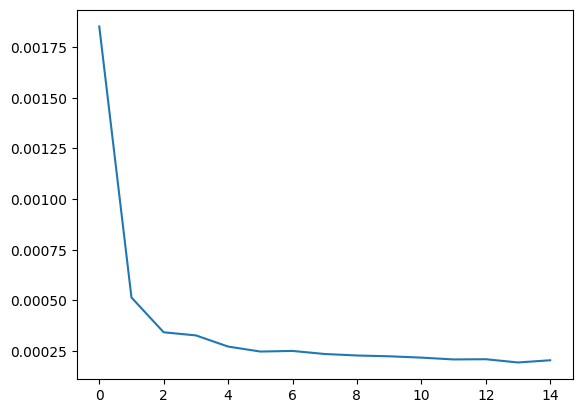

In [618]:
# define model
LSTM_model_with_Pos_rbk = Sequential()
LSTM_model_with_Pos_rbk.add(Masking(mask_value=mask, input_shape=(n_input, n_features)))
LSTM_model_with_Pos_rbk.add(LSTM(100, input_shape=(n_input, n_features)))
LSTM_model_with_Pos_rbk.add(Dense(6))
LSTM_model_with_Pos_rbk.compile(optimizer='adam', loss='mse')

LSTM_model_with_Pos_rbk.fit(generator,epochs=15)
loss_per_epoch = LSTM_model_with_Pos_rbk.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
first_eval_batch = generator[-n_input-1][0]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
test_predictions_30 = []
for i in range(len(test_for_LSTM)):
    
    # get the prediction value for the first batch
    current_pred = LSTM_model_with_Pos_rbk.predict(current_batch)[0]
    current_pred = current_pred[-1:] 
    
    # append the prediction into the array
    test_predictions_30.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[ array([scaled_test_for_LSTM[i][0] , test_for_LSTM['rbk_positive'].iloc[i] , test_for_LSTM['rbk_negative'].iloc[i]]) ]],axis=1)
true_predictions = scaler.inverse_transform(test_predictions_30)
test_for_LSTM['Predictions'] = true_predictions
columns_to_plot = ['Close', 'Predictions']
test_for_LSTM[columns_to_plot].plot(figsize=(14,5), marker='o', label = True)

In [ ]:
# define model
LSTM_model_with_Pos_rbk = Sequential()
LSTM_model_with_Pos_rbk.add(Masking(mask_value=mask, input_shape=(n_input, n_features)))
LSTM_model_with_Pos_rbk.add(LSTM(100, input_shape=(n_input, n_features)))
LSTM_model_with_Pos_rbk.add(Dense(5))
LSTM_model_with_Pos_rbk.add(Dense(1))
LSTM_model_with_Pos_rbk.compile(optimizer='adam', loss='mse')

In [ ]:
# # define model
# LSTM_model_with_Pos_rbk = Sequential()
# LSTM_model_with_Pos_rbk.add(Masking(mask_value=mask, input_shape=(n_input, n_features)))
# LSTM_model_with_Pos_rbk.add(LSTM(50, return_sequences=True))  # Первый слой LSTM
# LSTM_model_with_Pos_rbk.add(LSTM(50, return_sequences=True))  # Второй слой LSTM
# LSTM_model_with_Pos_rbk.add(LSTM(50))  # Третий (последний) слой LSTM, return_sequences=False по умолчанию
# LSTM_model_with_Pos_rbk.add(Dense(1))
# LSTM_model_with_Pos_rbk.compile(optimizer='adam', loss='mse')

In [ ]:
LSTM_model_with_Pos_rbk.fit(generator,epochs=15)

Epoch 1/15


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.0045
Epoch 2/15
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 4.9055e-04
Epoch 3/15
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 3.2739e-04
Epoch 4/15
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 3.0396e-04
Epoch 5/15
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 2.7938e-04
Epoch 6/15
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 2.2436e-04
Epoch 7/15
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 2.3246e-04
Epoch 8/15
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 2.4407e-04
Epoch 9/15
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 2.2316e-04
Epoch 10/15
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 2.4647e-04
Epoch 11/15
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 2.2731e-04
Epoch 12/15
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 2.2519e-04
Epoch 13/15
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 2.2275e-04
Epoch 14/15
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 3m

In [ ]:
LSTM_model_with_Pos_rbk.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_9 (Masking)             │ (None, 30, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 100)            │        42,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,517 (498.12 KB)

 Trainable params: 42,505 (166.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 85,012 (332.08 KB)

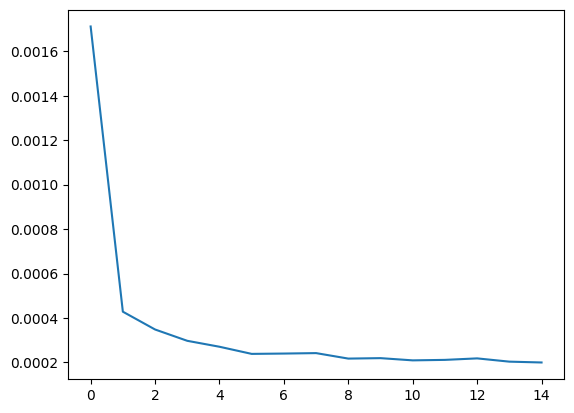

In [ ]:
loss_per_epoch = LSTM_model_with_Pos_rbk.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
first_eval_batch = generator[-n_input-1][0]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [ ]:
# test_predictions_30 = []
# for i in range(len(test_for_LSTM)):
    
#     # get the prediction value for the first batch
#     current_pred = LSTM_model_with_Pos_rbk.predict(current_batch)[0]
#     current_pred = current_pred[-1:] 
    
#     # append the prediction into the array
#     test_predictions_30.append(current_pred) 
    
#     # use the prediction to update the batch and remove the first value
#     current_batch = np.append(current_batch[:,1:,:],   [[ array([scaled_test_for_LSTM[i][0] , test_for_LSTM['rbk_positive'].iloc[i] , test_for_LSTM['rbk_negative'].iloc[i]]) ]]     ,axis=1)

In [ ]:
test_predictions_30 = []
for i in range(len(test_for_LSTM)):
    
    # get the prediction value for the first batch
    current_pred = LSTM_model_with_Pos_rbk.predict(current_batch)[0]
    current_pred = current_pred[-1:] 
    
    # append the prediction into the array
    test_predictions_30.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],  [[ array([scaled_test_for_LSTM[i][0] , test_for_LSTM['rbk_postive_cryptobert'].iloc[i] , test_for_LSTM['rbk_negative_cryptobert'].iloc[i], test_for_LSTM['rbk_neutral_cryptobert'].iloc[i] ]) ]]      ,axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions_30)
test_for_LSTM['Predictions'] = true_predictions

C:\Users\User\AppData\Local\Temp\ipykernel_38772\1492626813.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['Predictions'] = true_predictions


In [ ]:
true_predictions

array([[66880.10278768],
       [65311.58142129],
       [64603.51256744],
       [64112.99249464],
       [63836.11894363],
       [64926.46145804],
       [61914.23887561],
       [59416.42792658],
       [59831.31456683],
       [63246.98643273],
       [64383.53899723],
       [66030.18376785],
       [64248.25488219],
       [63286.62608638],
       [62144.17233249],
       [62602.91376166],
       [60356.50304095],
       [62503.44526001],
       [61036.83891194],
       [63443.43780987],
       [62481.64388506],
       [66315.82219295],
       [66012.07172263],
       [67723.41664707],
       [68465.71066121],
       [67683.93777693],
       [71903.01442756],
       [70602.37142659],
       [69843.72094936],
       [68452.30913831]])

<Axes: xlabel='date'>

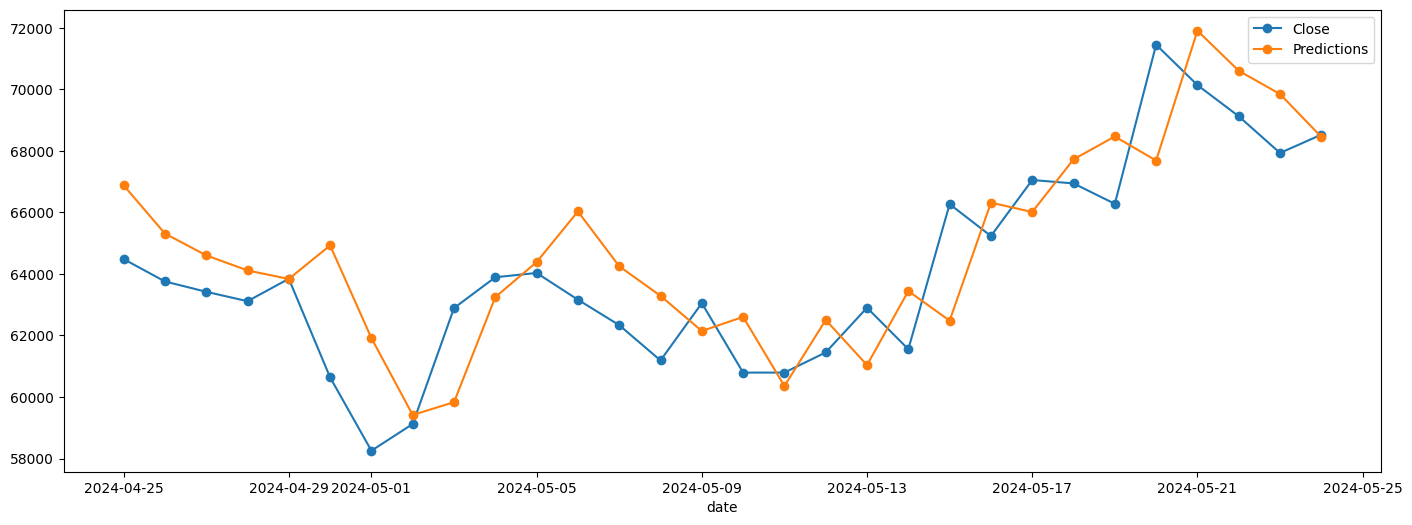

In [ ]:
columns_to_plot = ['Close', 'Predictions']
test_for_LSTM[columns_to_plot].plot(figsize=(17,6), marker='o', label = True)

In [ ]:
rmse=sqrt(mean_squared_error(test_for_LSTM['Close'],test_for_LSTM['Predictions']))
print(f"Root Mean squared error: {rmse}") 
print(f"Mean squared error: {mean_squared_error(test_for_LSTM['Close'],test_for_LSTM['Predictions'])}") 
print(f"SMAPE: {smape(test_for_LSTM['Close'],test_for_LSTM['Predictions'])}")

# Root Mean squared error: 1930.1425164308296
# Mean squared error: 3725450.133733935
# SMAPE: 2.3138564642636354

Root Mean squared error: 2051.3088220837667
Mean squared error: 4207867.88355869
SMAPE: 2.651266572385539


In [ ]:
train_for_LSTM

,Close,rbk_postive_cryptobert,rbk_negative_cryptobert,rbk_neutral_cryptobert
date,,,,
2014-09-17,457.334015,-1.000000,-1.000000,-1.000000
2014-09-18,424.440002,-1.000000,-1.000000,-1.000000
2014-09-19,394.795990,-1.000000,-1.000000,-1.000000
2014-09-20,408.903992,-1.000000,-1.000000,-1.000000
2014-09-21,398.821014,-1.000000,-1.000000,-1.000000
...,...,...,...,...
2024-04-20,64994.441406,0.505292,0.251978,0.242730
2024-04-21,64926.644531,0.245877,0.477805,0.276319
2024-04-22,66837.679688,0.226925,0.208175,0.564900


In [ ]:
test_for_LSTM

,Close,rbk_postive_cryptobert,rbk_negative_cryptobert,rbk_neutral_cryptobert,Predictions
date,,,,,
2024-04-25,64481.707031,0.251668,0.019659,0.728673,62448.661538
2024-04-26,63755.320312,0.199658,0.127271,0.673072,61145.871860
2024-04-27,63419.140625,0.404467,0.080275,0.515258,60487.780605
2024-04-28,63113.230469,0.062337,0.000062,0.937601,59930.070406
2024-04-29,63841.121094,0.282250,0.497083,0.220666,59802.608192
2024-04-30,60636.855469,0.116403,0.000079,0.883519,60901.732962
2024-05-01,58254.011719,0.149197,0.002709,0.848094,57398.208117
2024-05-02,59123.433594,0.322830,0.160696,0.516474,55385.989444
2024-05-03,62889.835938,0.299703,0.103700,0.596597,56145.478602


# Попробую добавить данные с ВК

In [637]:
vk_data_from_rubeart = pd.read_csv('vk_RuBeart_text_Sentiment.csv')
#vk_data_from_rubeart = vk_data_from_rubeart.rename(columns={'Дата и время публикации': 'publish_date'}) # переименовал в publish_date что бы привычнеебыло

In [638]:
vk_data_from_rubeart_v2 = pd.read_excel('vk_RuBeart_text_Sentiment_v2_excel.xlsx')

In [639]:
vk_data_from_rubeart = vk_data_from_rubeart_v2

In [640]:
vk_data_from_rubeart

,publish_date,vk_posotive_rubert,vk_negative_rubert
0,2022-10-19,0.527412,0.472588
1,2024-05-24,0.479314,0.520686
2,2024-05-23,0.000120,0.999880
3,2024-05-23,0.671547,0.328453
4,2024-05-23,0.550594,0.449406
...,...,...,...
12507,2017-04-12,0.553791,0.446209
12508,2017-04-05,0.503072,0.496928
12509,2017-04-05,0.443439,0.556561
12510,2017-04-05,0.418640,0.581360


In [641]:

# Убедимся, что publish_date в формате datetime
vk_data_from_rubeart['publish_date'] = pd.to_datetime(vk_data_from_rubeart['publish_date'])
# Шаг 2: Агрегация значений rbk_positive и rbk_negative по дням
vk_data_from_rubeart = vk_data_from_rubeart.groupby('publish_date').mean().reset_index()
# Преобразование publish_date в дату без времени
vk_data_from_rubeart['publish_date'] = vk_data_from_rubeart['publish_date'].apply(lambda x: x.date())

In [642]:

# Объединение данных
merged_df_VK_ruBert = pd.merge(my_df, vk_data_from_rubeart, how='left', left_on='date', right_on='publish_date')
merged_df_VK_ruBert.set_index('date', inplace=True)
merged_df_VK_ruBert.drop(columns=['publish_date'], inplace=True)
merged_df_VK_ruBert

,Close,vk_posotive_rubert,vk_negative_rubert
date,,,
2014-09-17,457.334015,NaN,NaN
2014-09-18,424.440002,NaN,NaN
2014-09-19,394.795990,NaN,NaN
2014-09-20,408.903992,NaN,NaN
2014-09-21,398.821014,NaN,NaN
...,...,...,...
2024-05-20,71448.195312,0.587997,0.412003
2024-05-21,70136.531250,0.500050,0.499950
2024-05-22,69122.335938,0.440496,0.559504


In [643]:
# Шаг 3: Замаскировать пропуски в данных rbk_RuBeart_Titles_Sentiment
merged_df_VK_ruBert['vk_posotive_rubert'] = np.ma.masked_invalid(merged_df_VK_ruBert['vk_posotive_rubert'])
merged_df_VK_ruBert['vk_negative_rubert'] = np.ma.masked_invalid(merged_df_VK_ruBert['vk_negative_rubert'])

# Замена маскированных значений на -1
merged_df_VK_ruBert['vk_posotive_rubert'] = merged_df_VK_ruBert['vk_posotive_rubert'].fillna(np.float64(-1))
merged_df_VK_ruBert['vk_negative_rubert'] = merged_df_VK_ruBert['vk_negative_rubert'].fillna(np.float64(-1))

# Данные почти готовы

In [644]:
# Данные почти готовы
n_input = 30
train_for_LSTM = merged_df_VK_ruBert.iloc[:-n_input]
test_for_LSTM = merged_df_VK_ruBert.iloc[-n_input:]

In [645]:
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(train_for_LSTM['Close'].values.reshape(-1, 1))
scaled_train_for_LSTM = scaler.transform(train_for_LSTM['Close'].values.reshape(-1, 1))
scaled_test_for_LSTM = scaler.transform(test_for_LSTM['Close'].values.reshape(-1, 1))

In [646]:
dataset = hstack((scaled_train_for_LSTM, train_for_LSTM['vk_posotive_rubert'].values.reshape((-1, 1)), train_for_LSTM['vk_negative_rubert'].values.reshape((-1, 1))))

In [647]:
generator = TimeseriesGenerator(dataset, scaled_train_for_LSTM, length=n_input, batch_size=1)
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[ 0.00383005 -1.         -1.          0.00337886 -1.         -1.
  0.00297225 -1.         -1.          0.00316576 -1.         -1.
  0.00302746 -1.         -1.          0.00307315 -1.         -1.
  0.00353455 -1.         -1.          0.00336192 -1.         -1.
  0.00320238 -1.         -1.          0.00310432 -1.         -1.
  0.00303705 -1.         -1.          0.00273063 -1.         -1.
  0.00270712 -1.         -1.          0.00286455 -1.         -1.
  0.00281889 -1.         -1.          0.00270171 -1.         -1.
  0.00248828 -1.         -1.          0.00206793 -1.         -1.
  0.00195331 -1.         -1.          0.00208456 -1.         -1.
  0.00216834 -1.         -1.          0.00239814 -1.         -1.
  0.00256391 -1.         -1.          0.0025164  -1.         -1.
  0.00252651 -1.         -1.          0.0027494  -1.         -1.
  0.00291214 -1.         -1.          0.00305556 -1.         -1.
  0.00297193 -1.         -1.          0.00280436 -1.         -1.        

In [648]:
n_features = X.shape[2]
n_features


3

In [649]:
type(X[0][1][1])

numpy.float64

In [650]:
mask = np.float64(-1)
type(mask)

numpy.float64

In [651]:
# define model
LSTM_model_with_Pos_vk_ru_bert = Sequential()
LSTM_model_with_Pos_vk_ru_bert.add(Masking(mask_value=mask, input_shape=(n_input, n_features)))
LSTM_model_with_Pos_vk_ru_bert.add(LSTM(100, input_shape=(n_input, n_features)))
LSTM_model_with_Pos_vk_ru_bert.add(Dense(6))
LSTM_model_with_Pos_vk_ru_bert.compile(optimizer='adam', loss='mse')

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [652]:
LSTM_model_with_Pos_vk_ru_bert.fit(generator,epochs=20)


Epoch 1/20


  42/3478 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.0969

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.0071
Epoch 2/20
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 4.6721e-04
Epoch 3/20
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 3.4562e-04
Epoch 4/20
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 2.9244e-04
Epoch 5/20
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 2.7784e-04
Epoch 6/20
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 2.1660e-04
Epoch 7/20
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 2.3785e-04
Epoch 8/20
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 2.0933e-04
Epoch 9/20
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 2.1161e-04
Epoch 10/20
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 2.0836e-04
Epoch 11/20
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 2.0529e-04
Epoch 12/20
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 2.2287e-04
Epoch 13/20
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 1.9803e-04
Epoch 14/20
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 3m

In [653]:
LSTM_model_with_Pos_vk_ru_bert.summary()

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_18 (Masking)            │ (None, 30, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 100)            │        41,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,620 (494.61 KB)

 Trainable params: 42,206 (164.87 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 84,414 (329.75 KB)

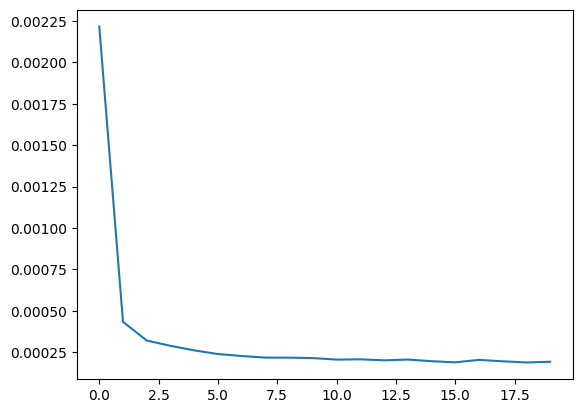

In [654]:
loss_per_epoch = LSTM_model_with_Pos_vk_ru_bert.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [655]:
first_eval_batch = generator[-n_input-1][0]
current_batch = first_eval_batch.reshape((1, n_input, n_features))


In [656]:
current_batch

array([[[0.95714052, 0.3641598 , 0.63584019],
        [0.95753862, 0.49296638, 0.50703362],
        [0.95023474, 0.51695266, 0.48304733],
        [0.96792354, 0.37458276, 0.62541726],
        [0.95623545, 0.47600288, 0.52399711],
        [0.95284032, 0.27868868, 0.72131129],
        [0.97599833, 0.15961661, 0.84038343],
        [0.95362001, 0.37588032, 0.62411971],
        [0.89525429, 0.29206101, 0.70793901],
        [0.90257666, 0.78530306, 0.21469697],
        [0.93725216, 0.56024808, 0.43975195],
        [0.92804566, 0.15254945, 0.84745056],
        [0.94256405, 0.5082669 , 0.49173315],
        [0.948962  , 0.30181556, 0.69818442],
        [0.98008185, 0.56056482, 0.43943521],
        [0.94589585, 0.53142204, 0.46857798],
        [0.9657691 , 0.43162192, 0.56837807],
        [0.95853681, 0.24779139, 0.75220859],
        [0.91924284, 0.37966086, 0.62033914],
        [0.87295828, 0.51890605, 0.48109399],
        [0.89925611, 0.45115514, 0.54884486],
        [0.86753671, 0.49952308, 0

In [657]:
current_pred = LSTM_model_with_Pos_vk_ru_bert.predict(current_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


In [658]:
current_pred[0][-1:]

array([0.91520673], dtype=float32)

In [659]:
scaled_test_for_LSTM[i][0]

0.8820143182489558

In [660]:
test_predictions_30 = []
for i in range(len(test_for_LSTM)):
    
    # get the prediction value for the first batch
    current_pred = LSTM_model_with_Pos_vk_ru_bert.predict(current_batch)[0]
    current_pred = current_pred[-1:] 
    
    # append the prediction into the array
    test_predictions_30.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],  [[ array([scaled_test_for_LSTM[i][0] , test_for_LSTM['vk_posotive_rubert'].iloc[i] , test_for_LSTM['vk_negative_rubert'].iloc[i]]) ]]      ,axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━

In [661]:
true_predictions = scaler.inverse_transform(test_predictions_30)
test_for_LSTM['Predictions'] = true_predictions
true_predictions

C:\Users\User\AppData\Local\Temp\ipykernel_16876\1130567352.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['Predictions'] = true_predictions


array([[66901.61301412],
       [64680.6538886 ],
       [64069.39843573],
       [63920.27824776],
       [64154.09223639],
       [62259.85824122],
       [61613.61282001],
       [58772.00326999],
       [59042.41506207],
       [61977.60061535],
       [64163.07873099],
       [63372.68871964],
       [63244.69200858],
       [62559.97587329],
       [61809.88168613],
       [62454.38021623],
       [61146.34551926],
       [60770.63790964],
       [61860.1591245 ],
       [63251.51878954],
       [62094.54237367],
       [66057.41701817],
       [64623.25852076],
       [66921.81524497],
       [67397.8734928 ],
       [66986.19817727],
       [71736.0516154 ],
       [70062.19532197],
       [69235.30745367],
       [67976.524657  ]])

<Axes: xlabel='date'>

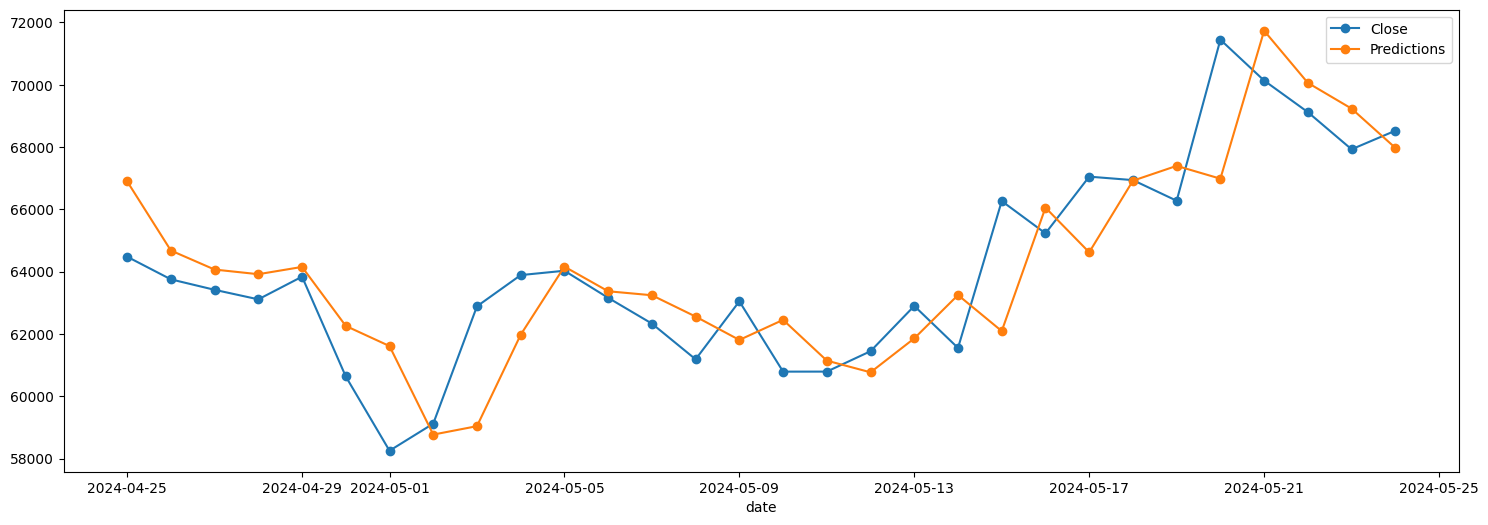

In [662]:
columns_to_plot = ['Close', 'Predictions']
test_for_LSTM[columns_to_plot].plot(marker='o', label = True)

In [663]:
rmse=sqrt(mean_squared_error(test_for_LSTM['Close'],test_for_LSTM['Predictions']))
print(f"Root Mean squared error: {rmse}") 
print(f"Mean squared error: {mean_squared_error(test_for_LSTM['Close'],test_for_LSTM['Predictions'])}") 
print(f"SMAPE: {smape(test_for_LSTM['Close'],test_for_LSTM['Predictions'])}")

# Root Mean squared error: 1859.5067007580676
# Mean squared error: 3457765.170164154
# SMAPE: 2.1516294030466154
# 1881.4220728783082

Root Mean squared error: 1849.5454506536717
Mean squared error: 3420818.3740336937
SMAPE: 2.2326404255035923


In [664]:
test_for_LSTM

,Close,vk_posotive_rubert,vk_negative_rubert,Predictions
date,,,,
2024-04-25,64481.707031,0.355467,0.644533,66901.613014
2024-04-26,63755.320312,0.446240,0.553760,64680.653889
2024-04-27,63419.140625,0.533704,0.466296,64069.398436
2024-04-28,63113.230469,-1.000000,-1.000000,63920.278248
2024-04-29,63841.121094,0.352191,0.647809,64154.092236
2024-04-30,60636.855469,0.537399,0.462601,62259.858241
2024-05-01,58254.011719,0.376633,0.623367,61613.612820
2024-05-02,59123.433594,0.174374,0.825626,58772.003270
2024-05-03,62889.835938,0.000097,0.999903,59042.415062


# Попробою объеденить ВК и РБК на РУ берте

In [471]:
merged_df_VK_ruBert

,Close,vk_posotive_rubert,vk_negative_rubert
date,,,
2014-09-17,457.334015,-1.000000,-1.000000
2014-09-18,424.440002,-1.000000,-1.000000
2014-09-19,394.795990,-1.000000,-1.000000
2014-09-20,408.903992,-1.000000,-1.000000
2014-09-21,398.821014,-1.000000,-1.000000
...,...,...,...
2024-05-20,71448.195312,0.587997,0.412003
2024-05-21,70136.531250,0.500050,0.499950
2024-05-22,69122.335938,0.440496,0.559504


In [472]:
rbk_RuBeart_Titles_Sentiment

,publish_date,rbk_positive,rbk_negative
0,2017-12-08,0.508701,0.491299
1,2018-02-07,0.368749,0.631251
2,2018-02-26,0.459262,0.540738
3,2018-02-28,0.490551,0.509449
4,2018-03-01,0.347643,0.652357
...,...,...,...
1921,2024-05-20,0.404926,0.595074
1922,2024-05-21,0.412522,0.587478
1923,2024-05-22,0.482541,0.517459
1924,2024-05-23,0.366537,0.633463


In [473]:
merged_df_VK_and_RBK_ruBert = pd.merge(merged_df_VK_ruBert, rbk_RuBeart_Titles_Sentiment, how='left', left_index=True, right_on='publish_date')
merged_df_VK_and_RBK_ruBert.drop(columns=['publish_date'], inplace=True)

In [474]:
# Шаг 3: Замаскировать пропуски в данных rbk_RuBeart_Titles_Sentiment
merged_df_VK_and_RBK_ruBert['rbk_positive'] = np.ma.masked_invalid(merged_df_VK_and_RBK_ruBert['rbk_positive'])
merged_df_VK_and_RBK_ruBert['rbk_negative'] = np.ma.masked_invalid(merged_df_VK_and_RBK_ruBert['rbk_negative'])

# Замена маскированных значений на -1
merged_df_VK_and_RBK_ruBert['rbk_positive'] = merged_df_VK_and_RBK_ruBert['rbk_positive'].fillna(np.float64(-1))
merged_df_VK_and_RBK_ruBert['rbk_negative'] = merged_df_VK_and_RBK_ruBert['rbk_negative'].fillna(np.float64(-1))

In [475]:
merged_df_VK_and_RBK_ruBert

,Close,vk_posotive_rubert,vk_negative_rubert,rbk_positive,rbk_negative
NaN,457.334015,-1.000000,-1.000000,-1.000000,-1.000000
NaN,424.440002,-1.000000,-1.000000,-1.000000,-1.000000
NaN,394.795990,-1.000000,-1.000000,-1.000000,-1.000000
NaN,408.903992,-1.000000,-1.000000,-1.000000,-1.000000
NaN,398.821014,-1.000000,-1.000000,-1.000000,-1.000000
...,...,...,...,...,...
1921.0,71448.195312,0.587997,0.412003,0.404926,0.595074
1922.0,70136.531250,0.500050,0.499950,0.412522,0.587478
1923.0,69122.335938,0.440496,0.559504,0.482541,0.517459
1924.0,67929.562500,0.422621,0.577379,0.366537,0.633463



# Данные почти готовы

In [479]:
n_input = 30
train_for_LSTM = merged_df_VK_and_RBK_ruBert.iloc[:-n_input]
test_for_LSTM = merged_df_VK_and_RBK_ruBert.iloc[-n_input:]

In [480]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_for_LSTM['Close'].values.reshape(-1, 1))
scaled_train_for_LSTM = scaler.transform(train_for_LSTM['Close'].values.reshape(-1, 1))
scaled_test_for_LSTM = scaler.transform(test_for_LSTM['Close'].values.reshape(-1, 1))

dataset = hstack((scaled_train_for_LSTM, train_for_LSTM['vk_posotive_rubert'].values.reshape((-1, 1)), train_for_LSTM['vk_negative_rubert'].values.reshape((-1, 1)), train_for_LSTM['rbk_positive'].values.reshape((-1, 1)), train_for_LSTM['rbk_negative'].values.reshape((-1, 1))))

generator = TimeseriesGenerator(dataset, scaled_train_for_LSTM, length=n_input, batch_size=1)
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[ 0.00383005 -1.         -1.         -1.         -1.          0.00337886
 -1.         -1.         -1.         -1.          0.00297225 -1.
 -1.         -1.         -1.          0.00316576 -1.         -1.
 -1.         -1.          0.00302746 -1.         -1.         -1.
 -1.          0.00307315 -1.         -1.         -1.         -1.
  0.00353455 -1.         -1.         -1.         -1.          0.00336192
 -1.         -1.         -1.         -1.          0.00320238 -1.
 -1.         -1.         -1.          0.00310432 -1.         -1.
 -1.         -1.          0.00303705 -1.         -1.         -1.
 -1.          0.00273063 -1.         -1.         -1.         -1.
  0.00270712 -1.         -1.         -1.         -1.          0.00286455
 -1.         -1.         -1.         -1.          0.00281889 -1.
 -1.         -1.         -1.          0.00270171 -1.         -1.
 -1.         -1.          0.00248828 -1.         -1.         -1.
 -1.          0.00206793 -1.         -1.        

In [481]:
n_features = X.shape[2]
n_features

5

In [493]:

# define model
LSTM_model_with_sent_vk_and_rbk_ru_bert = Sequential()
LSTM_model_with_sent_vk_and_rbk_ru_bert.add(Masking(mask_value=mask, input_shape=(n_input, n_features)))
LSTM_model_with_sent_vk_and_rbk_ru_bert.add(LSTM(150, input_shape=(n_input, n_features)))
LSTM_model_with_sent_vk_and_rbk_ru_bert.add(Dense(8))
LSTM_model_with_sent_vk_and_rbk_ru_bert.compile(optimizer='adam', loss='mse')
LSTM_model_with_sent_vk_and_rbk_ru_bert.fit(generator,epochs=15)

Epoch 1/15


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3478/3478 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 0.0064
Epoch 2/15
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 5.9159e-04
Epoch 3/15
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 4.5191e-04
Epoch 4/15
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 3.4125e-04
Epoch 5/15
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 3.0283e-04
Epoch 6/15
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 2.9930e-04
Epoch 7/15
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 2.5136e-04
Epoch 8/15
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 2.2394e-04
Epoch 9/15
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 2.5982e-04
Epoch 10/15
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 2.4988e-04
Epoch 11/15
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 1.8783e-04
Epoch 12/15
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 2.1703e-04
Epoch 13/15
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 2.1049e-04
Epoch 14/15
3478/3478 ━━━━━━━━━━━━━━━━━━━━ 12s 4m

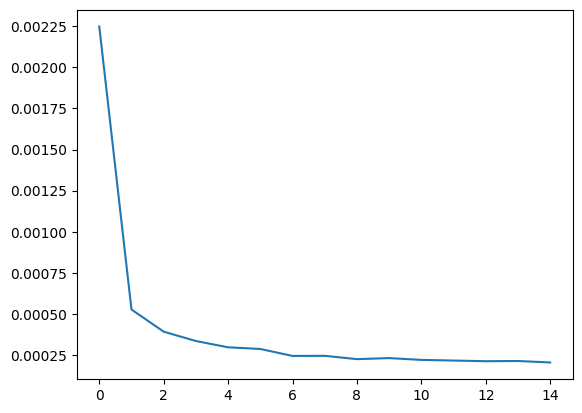

In [494]:
loss_per_epoch = LSTM_model_with_sent_vk_and_rbk_ru_bert.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [495]:

first_eval_batch = generator[-n_input-1][0]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [496]:
test_predictions_30 = []
for i in range(len(test_for_LSTM)):
    
    # get the prediction value for the first batch
    current_pred = LSTM_model_with_Pos_vk_ru_bert.predict(current_batch)[0]
    current_pred = current_pred[-1:] 
    
    # append the prediction into the array
    test_predictions_30.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],  [[ array([scaled_test_for_LSTM[i][0] , test_for_LSTM['vk_posotive_rubert'].iloc[i] , test_for_LSTM['vk_negative_rubert'].iloc[i] , test_for_LSTM['rbk_positive'].iloc[i] , test_for_LSTM['rbk_negative'].iloc[i]  ]) ]]      ,axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [497]:
true_predictions = scaler.inverse_transform(test_predictions_30)
test_for_LSTM['Predictions'] = true_predictions

C:\Users\User\AppData\Local\Temp\ipykernel_38772\1492626813.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_for_LSTM['Predictions'] = true_predictions


<Axes: >

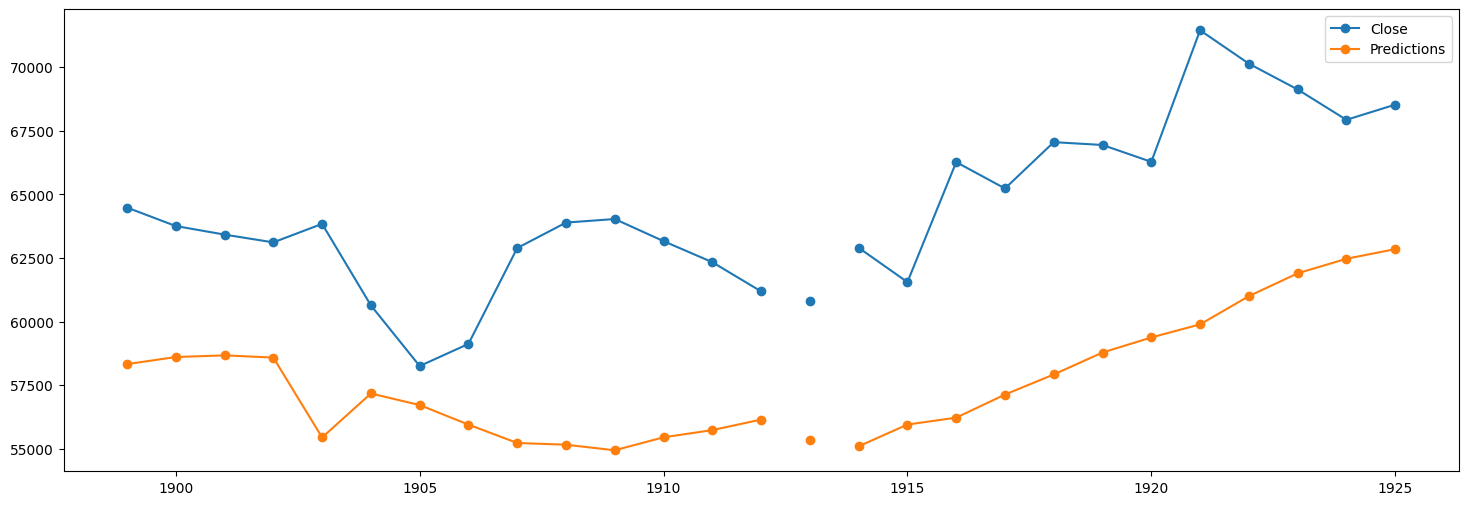

In [498]:
columns_to_plot = ['Close', 'Predictions']
test_for_LSTM[columns_to_plot].plot(figsize=(18,6), marker='o', label = True)

In [499]:
rmse=sqrt(mean_squared_error(test_for_LSTM['Close'],test_for_LSTM['Predictions']))
print(f"Root Mean squared error: {rmse}") 
print(f"Mean squared error: {mean_squared_error(test_for_LSTM['Close'],test_for_LSTM['Predictions'])}") 
print(f"SMAPE: {smape(test_for_LSTM['Close'],test_for_LSTM['Predictions'])}")

Root Mean squared error: 7003.195206635248
Mean squared error: 49044743.102238916
SMAPE: 10.911410771603306
